# INN Hotels Project

# Problem Statement

## Context

A significant number of hotel bookings are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with. Such losses are particularly high on last-minute cancellations.

The new technologies involving online booking channels have dramatically changed customers’ booking possibilities and behavior. This adds a further dimension to the challenge of how hotels handle cancellations, which are no longer limited to traditional booking and guest characteristics.

The cancellation of bookings impact a hotel on various fronts:
* Loss of resources (revenue) when the hotel cannot resell the room.
* Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms.
* Lowering prices last minute, so the hotel can resell a room, resulting in reducing the profit margin.
* Human resources to make arrangements for the guests.

## Objective
The increasing number of cancellations calls for a Machine Learning based solution that can help in predicting which booking is likely to be canceled. INN Hotels Group has a chain of hotels in Portugal, they are facing problems with the high number of booking cancellations and have reached out to your firm for data-driven solutions. You as a data scientist have to analyze the data provided to find which factors have a high influence on booking cancellations, build a predictive model that can predict which booking is going to be canceled in advance, and help in formulating profitable policies for cancellations and refunds.

## Data Description
The data contains the different attributes of customers' booking details. The detailed data dictionary is given below.


**Data Dictionary**

* Booking_ID: unique identifier of each booking
* no_of_adults: Number of adults
* no_of_children: Number of Children
* no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* type_of_meal_plan: Type of meal plan booked by the customer:
    * Not Selected – No meal plan selected
    * Meal Plan 1 – Breakfast
    * Meal Plan 2 – Half board (breakfast and one other meal)
    * Meal Plan 3 – Full board (breakfast, lunch, and dinner)
* required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
* room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
* lead_time: Number of days between the date of booking and the arrival date
* arrival_year: Year of arrival date
* arrival_month: Month of arrival date
* arrival_date: Date of the month
* market_segment_type: Market segment designation.
* repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
* no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
* no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
* avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
* no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
* booking_status: Flag indicating if the booking was canceled or not.

## Importing necessary libraries,data and creating functions

In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# setting the precision of floating numbers to 5 decimal points
pd.set_option("display.float_format", lambda x: "%.5f" % x)

# Library to split data
from sklearn.model_selection import train_test_split

# To build model for prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV


# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)


In [ ]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram

    # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )
    ax_hist2.text(data[feature].mean(), plt.ylim()[1] * 0.9, f'Mean: {data[feature].mean():.2f}',color='green', ha='center', va='center', backgroundcolor='white')

    # Add median to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )
    ax_hist2.text(data[feature].median(), plt.ylim()[1] * 0.8, f'Median: {data[feature].median():.2f}',color='red', ha='center', va='center', backgroundcolor='white')
    plt.show();


In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    #plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette='viridis',
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot


In [ ]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0],palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette = 'gist_rainbow'
    )

    plt.tight_layout()
    plt.show()

In [ ]:
### function to  print the category counts and plot a stacked bar chartt of the  independent variable wrt target

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
# defining a function to plot the confusion_matrix of a classification model


def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
# we will define a function to check VIF
def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]
    return vif

In [ ]:
#format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded off to 2 decimal places

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Read the data
hotel = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Supervised Learning Classification/Project4/INNHotelsGroup.csv")

In [ ]:
# copying data to another variable to avoid any changes to original data
data = hotel.copy()


## Data Overview


### Displaying the first few rows of the dataset

In [ ]:
data.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   
3        Room_Type 1        211          2018              5            20   
4        Room_Type 1         48          2018              4            11   

  market_segment_type  repeated_guest  no_of_previous_cancellations  \
0             Offline               0                             0   
1              Online               0                             0   
2              Online               0                             0   
3              Online               0                             0   
4              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

### Displaying the last few rows of the dataset

In [ ]:
data.tail()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
36270   INN36271             3               0                     2   
36271   INN36272             2               0                     1   
36272   INN36273             2               0                     2   
36273   INN36274             2               0                     0   
36274   INN36275             2               0                     1   

       no_of_week_nights type_of_meal_plan  required_car_parking_space  \
36270                  6       Meal Plan 1                           0   
36271                  3       Meal Plan 1                           0   
36272                  6       Meal Plan 1                           0   
36273                  3      Not Selected                           0   
36274                  2       Meal Plan 1                           0   

      room_type_reserved  lead_time  arrival_year  arrival_month  \
36270        Room_Type 4         85          2018              8   
36271        Room_Type 1        228          2018             10   
36272        Room_Type 1        148          2018              7   
36273        Room_Type 1         63          2018              4   
36274        Room_Type 1        207          2018             12   

       arrival_date market_segment_type  repeated_guest  \
36270             3              Online               0   
36271            17              Online               0   
36272             1              Online               0   
36273            21              Online               0   
36274            30             Offline               0   

       no_of_previous_cancellations  no_of_previous_bookings_not_canceled  \
36270                             0                                     0   
36271                             0                                     0   
36272                             0                                     0   
36273                             0                                     0   
36274                             0                                     0   

       avg_price_per_room  no_of_special_requests booking_status  
36270              167.80                       1   Not_Canceled  
36271               90.95                       2       Canceled  
36272               98.39                       2   Not_Canceled  
36273               94.50                       0       Canceled  
36274              161.67                       0   Not_Canceled

- The dataset has been loaded successfully

### Checking the shape of the dataset

In [ ]:
data.shape

(36275, 19)

*  The dataset has 36275 rows and 19 columns

### Checking the data types of the columns for the dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

* There are a total of 36275 non-null observations in each of the columns

* There are 13 columns of type **int64**
* There is only 1 column called avg_price_per_room of type **float64**

* 'Booking_ID', 'type_of_meal_plan', 'room_type_reserved', 'market_segment_type' and 'booking_status' are **objects**

### Getting the statistical summary for the numerical variables

In [ ]:
data.describe().T

count    mean   std     min     25%  \
no_of_adults                         36275.00    1.84  0.52    0.00    2.00   
no_of_children                       36275.00    0.11  0.40    0.00    0.00   
no_of_weekend_nights                 36275.00    0.81  0.87    0.00    0.00   
no_of_week_nights                    36275.00    2.20  1.41    0.00    1.00   
required_car_parking_space           36275.00    0.03  0.17    0.00    0.00   
lead_time                            36275.00   85.23 85.93    0.00   17.00   
arrival_year                         36275.00 2017.82  0.38 2017.00 2018.00   
arrival_month                        36275.00    7.42  3.07    1.00    5.00   
arrival_date                         36275.00   15.60  8.74    1.00    8.00   
repeated_guest                       36275.00    0.03  0.16    0.00    0.00   
no_of_previous_cancellations         36275.00    0.02  0.37    0.00    0.00   
no_of_previous_bookings_not_canceled 36275.00    0.15  1.75    0.00    0.00   
avg_price_per_room                   36275.00  103.42 35.09    0.00   80.30   
no_of_special_requests               36275.00    0.62  0.79    0.00    0.00   

                                         50%     75%     max  
no_of_adults                            2.00    2.00    4.00  
no_of_children                          0.00    0.00   10.00  
no_of_weekend_nights                    1.00    2.00    7.00  
no_of_week_nights                       2.00    3.00   17.00  
required_car_parking_space              0.00    0.00    1.00  
lead_time                              57.00  126.00  443.00  
arrival_year                         2018.00 2018.00 2018.00  
arrival_month                           8.00   10.00   12.00  
arrival_date                           16.00   23.00   31.00  
repeated_guest                          0.00    0.00    1.00  
no_of_previous_cancellations            0.00    0.00   13.00  
no_of_previous_bookings_not_canceled    0.00    0.00   58.00  
avg_price_per_room                     99.45  120.00  540.00  
no_of_special_requests                  0.00    1.00    5.00

*  'avg_price_per_room' ranges from 0 to 540 euros with mean at 103.42 euros
   
     * The minimum price is 0, indicating some bookings may have been free or had special pricing.

*  no_of_previous_cancellations has maximum value of 13
* no_of_previous_bookings_not_canceled has maximum value of 58
* lead-time: has a mean of 85 days while the median number of days is 57.
* repeated_guest: Only a small percentage of guests (approximately 2.6%) are repeated guests, as indicated by the mean value of 0.03.



### Getting the statistical summary for the categorical variables

In [ ]:
data.describe(include = ['object']).T

count unique           top   freq
Booking_ID           36275  36275      INN00001      1
type_of_meal_plan    36275      4   Meal Plan 1  27835
room_type_reserved   36275      7   Room_Type 1  28130
market_segment_type  36275      5        Online  23214
booking_status       36275      2  Not_Canceled  24390

### Check for missing values

In [ ]:
# missing value check
data.isna().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

* There are no missing values in any of the columns

### Check for Duplicate Values


In [ ]:
data.duplicated().sum()

0

* There are no duplicated entries in the dataset

In [ ]:
# checking for unique values in Booking_ID column
data['Booking_ID'].nunique()

36275

*  Since all the values in Booking_ID are unique we can drop it

In [ ]:
data = data.drop('Booking_ID', axis = 1)

In [ ]:
data.head()

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0             2               0                     1                  2   
1             2               0                     2                  3   
2             1               0                     2                  1   
3             2               0                     0                  2   
4             2               0                     1                  1   

  type_of_meal_plan  required_car_parking_space room_type_reserved  lead_time  \
0       Meal Plan 1                           0        Room_Type 1        224   
1      Not Selected                           0        Room_Type 1          5   
2       Meal Plan 1                           0        Room_Type 1          1   
3       Meal Plan 1                           0        Room_Type 1        211   
4      Not Selected                           0        Room_Type 1         48   

   arrival_year  arrival_month  arrival_date market_segment_type  \
0          2017             10             2             Offline   
1          2018             11             6              Online   
2          2018              2            28              Online   
3          2018              5            20              Online   
4          2018              4            11              Online   

   repeated_guest  no_of_previous_cancellations  \
0               0                             0   
1               0                             0   
2               0                             0   
3               0                             0   
4               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. What are the busiest months in the hotel?
2. Which market segment do most of the guests come from?
3. Hotel rates are dynamic and change according to demand and customer demographics. What are the differences in room prices in different market segments?
4. What percentage of bookings are canceled?
5. Repeating guests are the guests who stay in the hotel often and are important to brand equity. What percentage of repeating guests cancel?
6. Many guests have special requirements when booking a hotel room. Do these requirements affect booking cancellation?

**What are the busiest months in the hotel?**

We can check which are the busiest months in 2017 and 2018 separately

In [ ]:
#To extract data for 2017
df = data[data['arrival_year'] == 2017]
df['arrival_month'].value_counts()

arrival_month
10    1913
9     1649
8     1014
12     928
11     647
7      363
Name: count, dtype: int64

In [ ]:
##To extract data for 2017
df_2018 = data[data['arrival_year'] == 2018]
df_2018['arrival_month'].value_counts()

arrival_month
10    3404
6     3203
9     2962
8     2799
4     2736
5     2598
7     2557
3     2358
11    2333
12    2093
2     1704
1     1014
Name: count, dtype: int64

Observations:

* For 2017,the busiest months are October followed by September and August
*For 2018, October is the busiest month followed by June and September

**Which market segment do most of the guests come from?**

In [ ]:
data['market_segment_type'].value_counts()

market_segment_type
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: count, dtype: int64

In [ ]:
data['market_segment_type'].value_counts(normalize = True)

market_segment_type
Online          0.64
Offline         0.29
Corporate       0.06
Complementary   0.01
Aviation        0.00
Name: proportion, dtype: float64

* **23214 (~64%) of the 36275 total bookings are made online.**

**Hotel rates are dynamic and change according to demand and customer demographics. What are the differences in room prices in different market segments?**

In [ ]:
data.groupby(['market_segment_type'])['avg_price_per_room'].mean().sort_values(ascending = False)

market_segment_type
Online          112.26
Aviation        100.70
Offline          91.63
Corporate        82.91
Complementary     3.14
Name: avg_price_per_room, dtype: float64

* Online bookings yield the highest average price per room ($112.25), followed by bookings through Aviation and Offline market segments.

* Complementary bookings yield the least average price per room $3.14

**What percentage of bookings are canceled?**

In [ ]:
data['booking_status'].value_counts(normalize = True)

booking_status
Not_Canceled   0.67
Canceled       0.33
Name: proportion, dtype: float64

* Of the total bookings ~33% of the bookings were canceled

**Repeating guests are the guests who stay in the hotel often and are important to brand equity. What percentage of repeating guests cancel?**




In [ ]:
data.groupby('repeated_guest')['booking_status'].value_counts(normalize = True)

repeated_guest  booking_status
0               Not_Canceled     0.66
                Canceled         0.34
1               Not_Canceled     0.98
                Canceled         0.02
Name: proportion, dtype: float64

In [ ]:
data.groupby('repeated_guest')['booking_status'].value_counts()

repeated_guest  booking_status
0               Not_Canceled      23476
                Canceled          11869
1               Not_Canceled        914
                Canceled             16
Name: count, dtype: int64

* repeated_guest = 1 , are the repeating guests
* Only 16 (~2%) of the 930 total bookings made by repeated guest were cancelled.

**Many guests have special requirements when booking a hotel room. Do these requirements affect booking cancellation?**

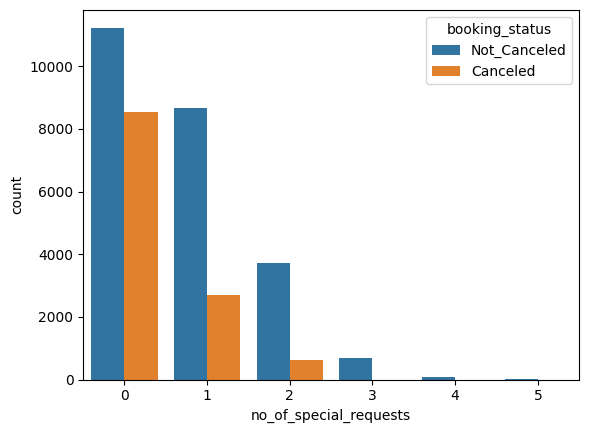

In [ ]:
sns.countplot(data = data, x = 'no_of_special_requests', hue = 'booking_status')
plt.show()

In [ ]:
data.groupby(['no_of_special_requests'])['booking_status'].value_counts(normalize = True)

no_of_special_requests  booking_status
0                       Not_Canceled     0.57
                        Canceled         0.43
1                       Not_Canceled     0.76
                        Canceled         0.24
2                       Not_Canceled     0.85
                        Canceled         0.15
3                       Not_Canceled     1.00
4                       Not_Canceled     1.00
5                       Not_Canceled     1.00
Name: proportion, dtype: float64


* Bookings with 0 special requests had the maximum % of cancellation - 43%
* **As the number of special requests made by customers increase, the proportion of bookings cancelled decreases.**
*Guests with 2 or more special requests are much less likely to cancel.
*Guests with 3 or 4 or 5 special requests never canceled

## Univariate Analysis

### **Observations on average price per room**

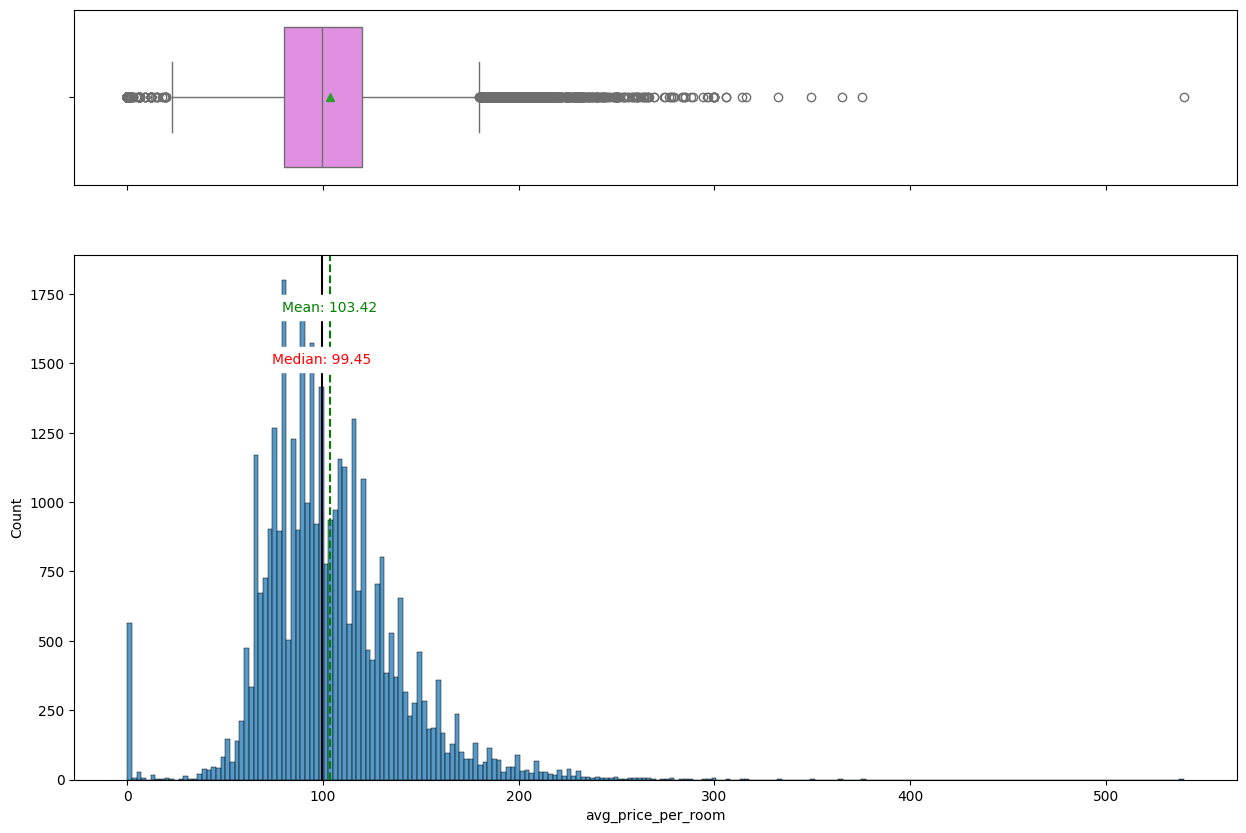

In [ ]:
histogram_boxplot(data, "avg_price_per_room")

In [ ]:
data['avg_price_per_room'].describe()

count   36275.00
mean      103.42
std        35.09
min         0.00
25%        80.30
50%        99.45
75%       120.00
max       540.00
Name: avg_price_per_room, dtype: float64

In [ ]:
# how many free rooms does the hotel give away?
data[data["avg_price_per_room"] == 0 ]

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
63                1               0                     0                  1   
145               1               0                     0                  2   
209               1               0                     0                  0   
266               1               0                     0                  2   
267               1               0                     2                  1   
...             ...             ...                   ...                ...   
35983             1               0                     0                  1   
36080             1               0                     1                  1   
36114             1               0                     0                  1   
36217             2               0                     2                  1   
36250             1               0                     0                  2   

      type_of_meal_plan  required_car_parking_space room_type_reserved  \
63          Meal Plan 1                           0        Room_Type 1   
145         Meal Plan 1                           0        Room_Type 1   
209         Meal Plan 1                           0        Room_Type 1   
266         Meal Plan 1                           0        Room_Type 1   
267         Meal Plan 1                           0        Room_Type 1   
...                 ...                         ...                ...   
35983       Meal Plan 1                           0        Room_Type 7   
36080       Meal Plan 1                           0        Room_Type 7   
36114       Meal Plan 1                           0        Room_Type 1   
36217       Meal Plan 1                           0        Room_Type 2   
36250       Meal Plan 2                           0        Room_Type 1   

       lead_time  arrival_year  arrival_month  arrival_date  \
63             2          2017              9            10   
145           13          2018              6             1   
209            4          2018              2            27   
266            1          2017              8            12   
267            4          2017              8            23   
...          ...           ...            ...           ...   
35983          0          2018              6             7   
36080          0          2018              3            21   
36114          1          2018              3             2   
36217          3          2017              8             9   
36250          6          2017             12            10   

      market_segment_type  repeated_guest  no_of_previous_cancellations  \
63          Complementary               0                             0   
145         Complementary               1                             3   
209         Complementary               0                             0   
266         Complementary               1                             0   
267         Complementary               0                             0   
...                   ...             ...                           ...   
35983       Complementary               1                             4   
36080       Complementary               1                             3   
36114              Online               0                             0   
36217              Online               0                             0   
36250              Online               0                             0   

       no_of_previous_bookings_not_canceled  avg_price_per_room  \
63                                        0                0.00   
145                                       5                0.00   
209                                       0                0.00   
266                                       1                0.00   
267                                       0                0.00   
...                                     ...                 ...   
35983                         

*Hotels give away almost 545 rooms for free

In [ ]:
data.loc[data['avg_price_per_room']==0,'market_segment_type'].value_counts()

market_segment_type
Complementary    354
Online           191
Name: count, dtype: int64

*  Bookings with avg_price_per_room as 0 belongs to the market segment type Complementary and Online

In [ ]:
# Calculating the 25th quantile
Q1 = data["avg_price_per_room"].quantile(0.25)

# Calculating the 75th quantile
Q3 = data['avg_price_per_room'].quantile(.75) ## Complete the code to calculate 75th quantile for average price per room

# Calculating IQR
IQR = Q3 - Q1

# Calculating value of upper whisker
Upper_Whisker = Q3 + 1.5 * IQR
Upper_Whisker

179.55

In [ ]:
# assigning the outliers the value of upper whisker
data.loc[data["avg_price_per_room"] >= 500, "avg_price_per_room"] = Upper_Whisker

**Observations:**
* avg_price_per_room ranges from 0 to $540
*   There are 545 bookings with an average price per room to be equal to 0.The  'market_segment_type of these bookings were -'Complementary' or 'Online'

* Average price per room equal to or above $500 were treated


### **Observations on lead time**

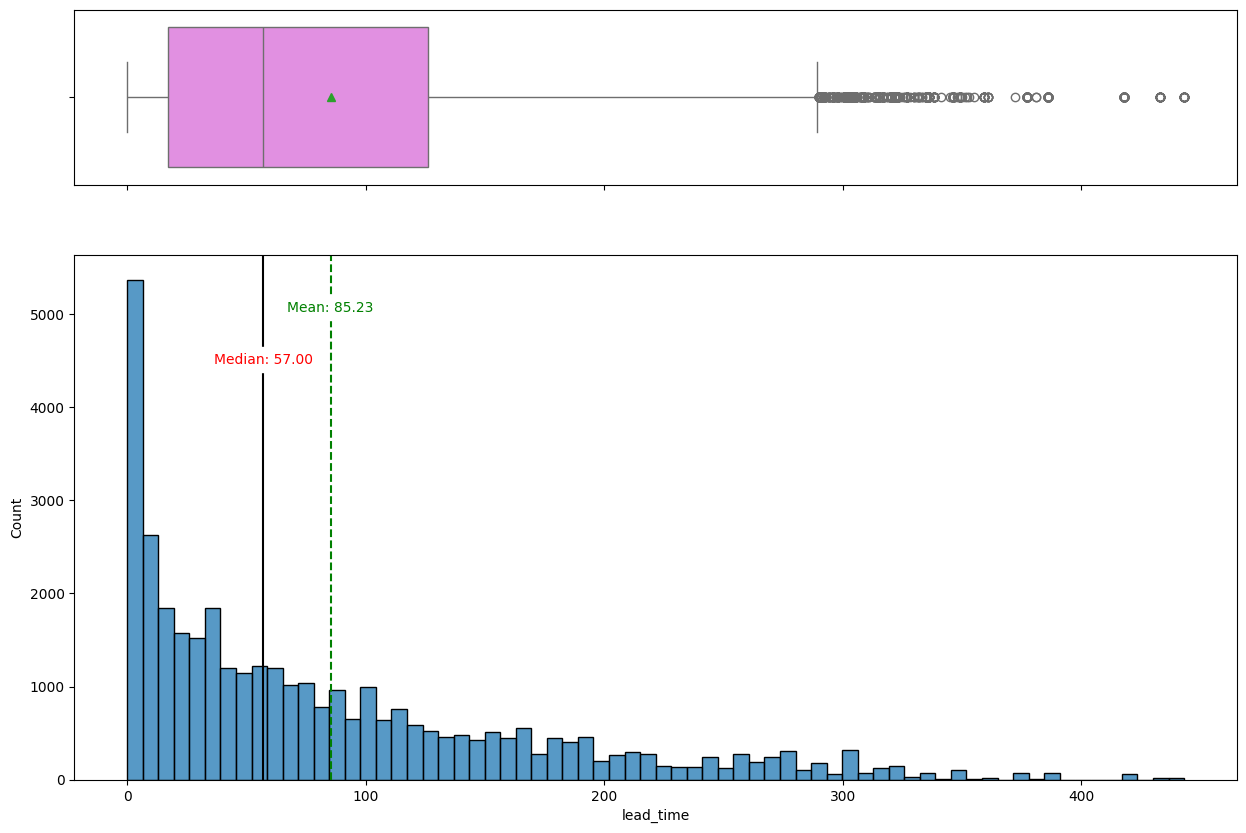

In [ ]:
histogram_boxplot(data, "lead_time")

In [ ]:
data['lead_time'].describe()

count   36275.00
mean       85.23
std        85.93
min         0.00
25%        17.00
50%        57.00
75%       126.00
max       443.00
Name: lead_time, dtype: float64

**Observations:**
*   Lead time ranges from 0 to 443 days with mean around 85.23 days
* Lead Time is skewed right with several outliers

### **Observations on number of previous booking cancellations**

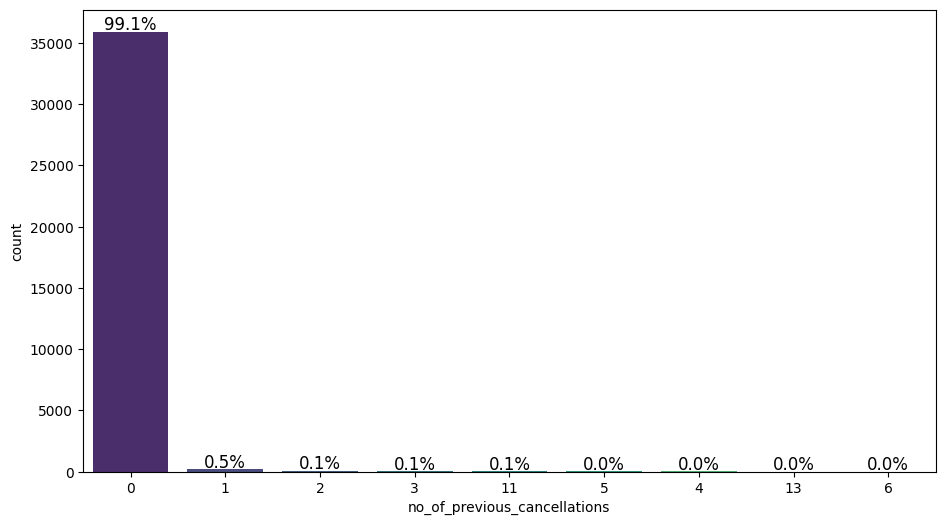

In [ ]:
labeled_barplot(data, "no_of_previous_cancellations",perc=True)

In [ ]:
data['no_of_previous_cancellations'].describe()

count   36275.00
mean        0.02
std         0.37
min         0.00
25%         0.00
50%         0.00
75%         0.00
max        13.00
Name: no_of_previous_cancellations, dtype: float64

* For ~99.1% of bookings number of previous cancellations is 0
*  The average number of previous cancellations is .023 and it ranges from 0 -13


### **Observations on number of previous booking not canceled**

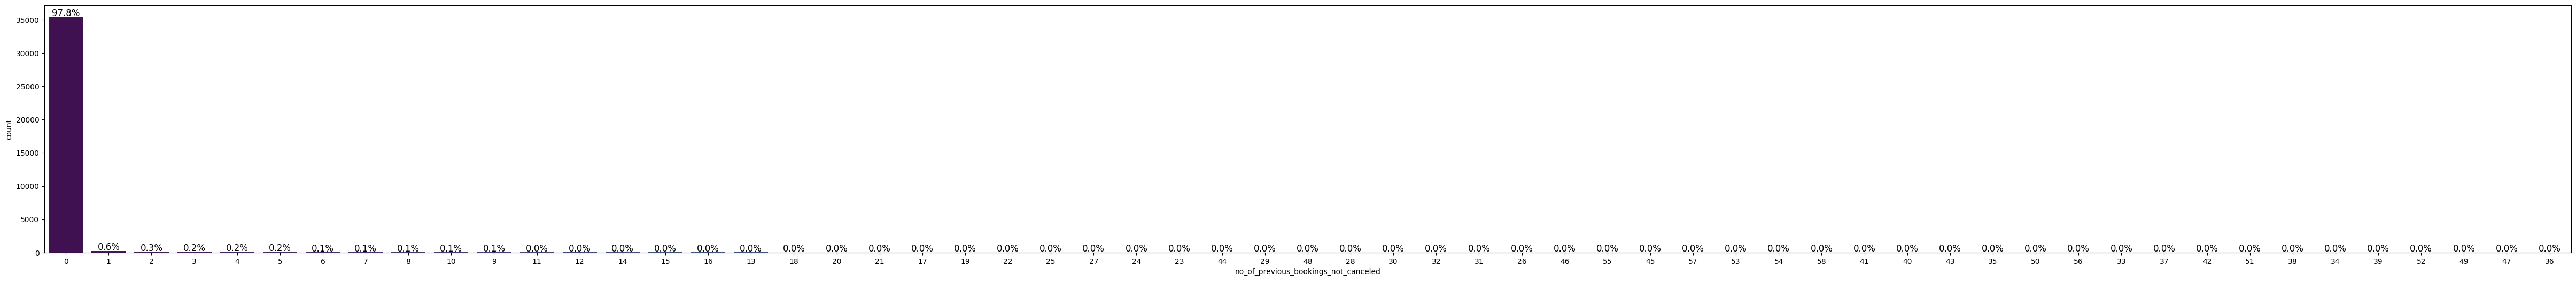

In [ ]:
labeled_barplot(data, "no_of_previous_bookings_not_canceled",perc=True)

In [ ]:
data['no_of_previous_bookings_not_canceled'].describe()

count   36275.00
mean        0.15
std         1.75
min         0.00
25%         0.00
50%         0.00
75%         0.00
max        58.00
Name: no_of_previous_bookings_not_canceled, dtype: float64

*   No of previous bookings not canceled ranges from 0 to 58
* For almost 97.8 % of the total bookings the no of previous bookings not canceled is 0
*The average number of previous bookings not canceled is .15

### **Observations on number of adults**

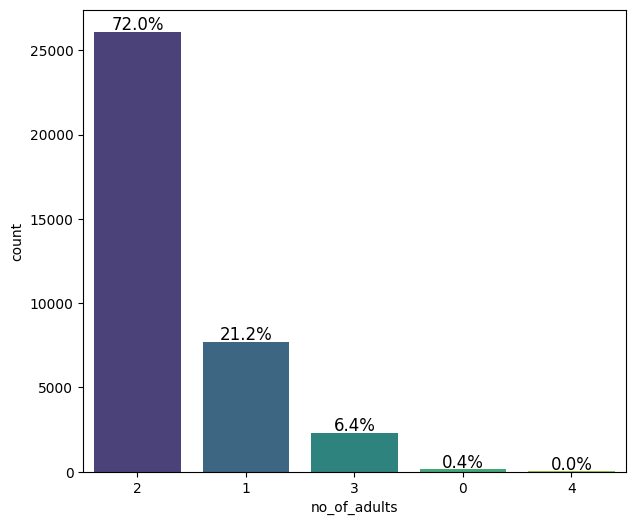

In [ ]:
labeled_barplot(data, "no_of_adults",perc=True)

In [ ]:
data['no_of_adults'].value_counts()

no_of_adults
2    26108
1     7695
3     2317
0      139
4       16
Name: count, dtype: int64

*  In `78.4% of the bookings included two or more adults, indicative of a couple or family traveling for pleasure
*~21% of bookings were for a single adult, indicative of a businessperson travelling for work
* In 139 bookings no adults were present

### **Observations on number of children**

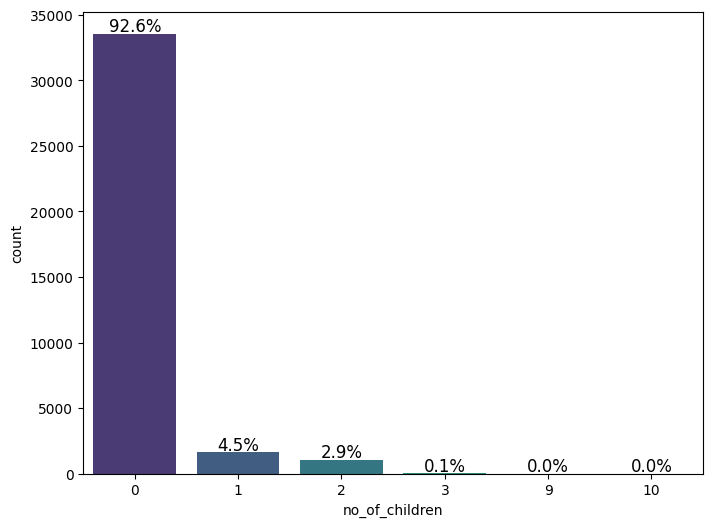

In [ ]:
labeled_barplot(data, "no_of_children",perc=True)

In [ ]:
data['no_of_children'].value_counts()

no_of_children
0     33577
1      1618
2      1058
3        19
9         2
10        1
Name: count, dtype: int64

*  There are 2 bookings where the no of children is 9 and 1 booking with no of children =10

In [ ]:
#replacing 9,10 children with 3
data['no_of_children'] = data['no_of_children'].replace([9,10],3)

In [ ]:
data['no_of_children'].value_counts()

no_of_children
0    33577
1     1618
2     1058
3       22
Name: count, dtype: int64

*  **~93% of bookings included no children.**

In [ ]:
df1 = data[(data['no_of_children'] >= 1) & (data['no_of_adults'] <1)]
df1.shape

(139, 18)

*  In 139 bookings,only kids were mentioned in the bookings.

**Observations:**
*  **~93% of bookings included no children.**
* 139 bookings had only kids mentioned in the bookings.
*Booking with 9 to 10 children were treated  and replaced with 3

### **Observations on required car parking space**

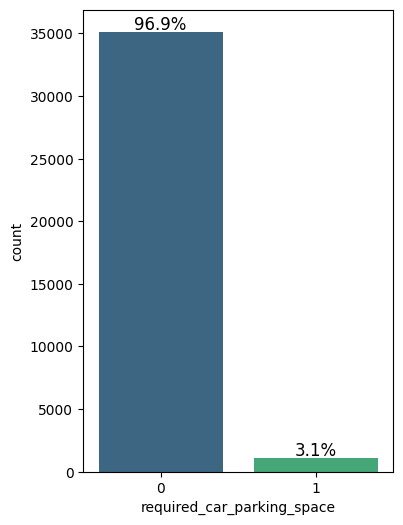

In [ ]:
labeled_barplot(data, "required_car_parking_space",perc=True)

**Observations:**
*  ~97% of guests did not require a parking space and not a single booking required more than one parking space.

### **Observations on number of week nights**

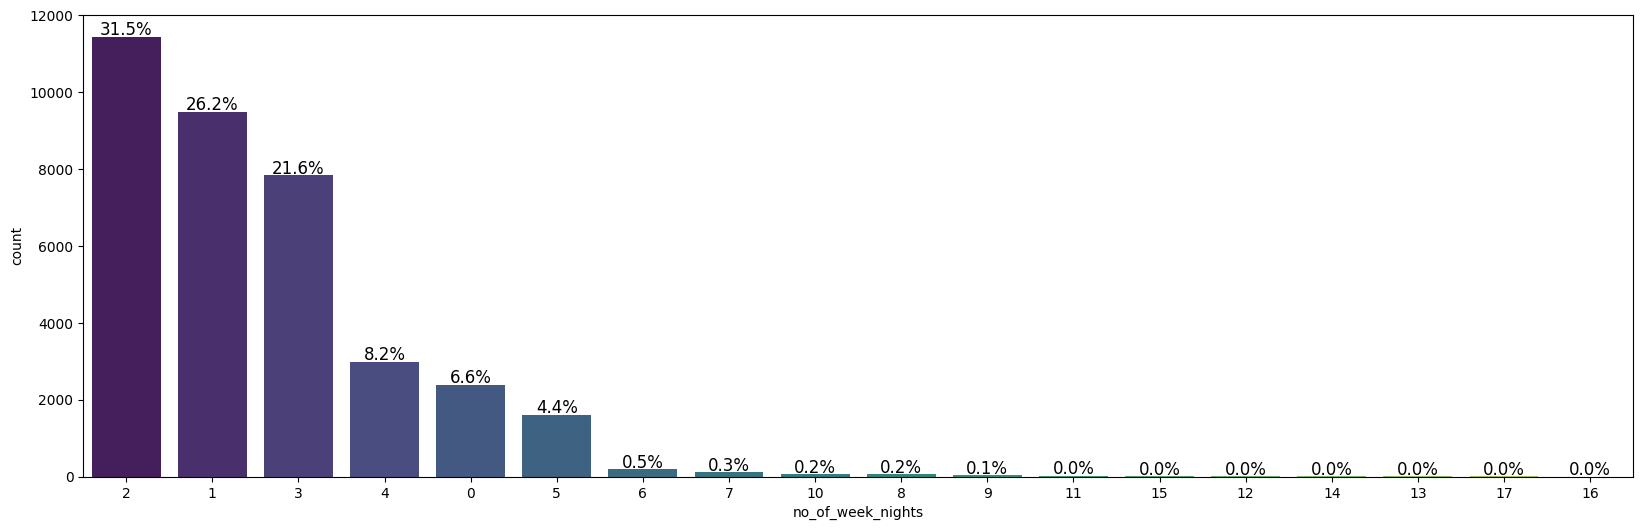

In [ ]:
labeled_barplot(data, "no_of_week_nights",perc=True)

**Observations:**
*  Number of week nights booked ranges from 0 to 16
* 2 week nights have the highest frequency,accounting for 31.5% of the bookings
* A majority of week nights include stays between 1-3 days

### **Observations on number of weekend nights**

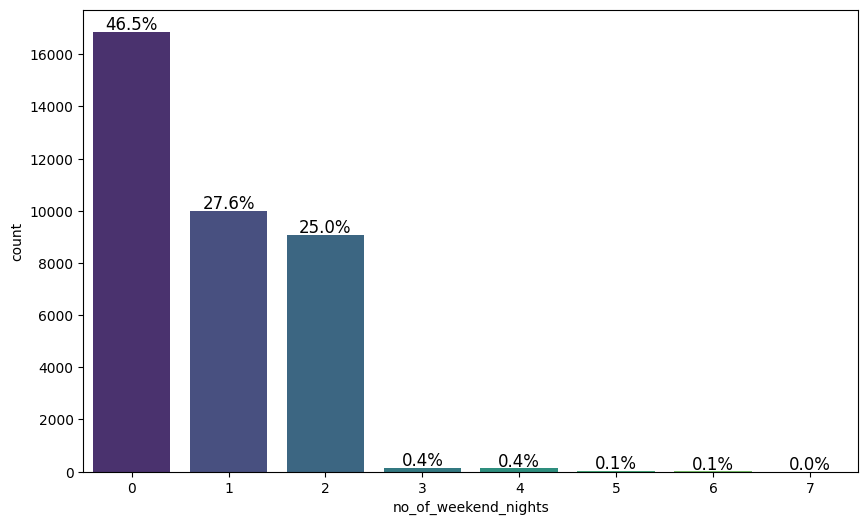

In [ ]:
labeled_barplot(data, "no_of_weekend_nights",perc=True)

*  46.5% of bookings do not include a weekend night
* 27.6% of total bookings had 1 weekend night
* 25% of total bookings had 2 weekend nights

### **Observations on type of meal plan**

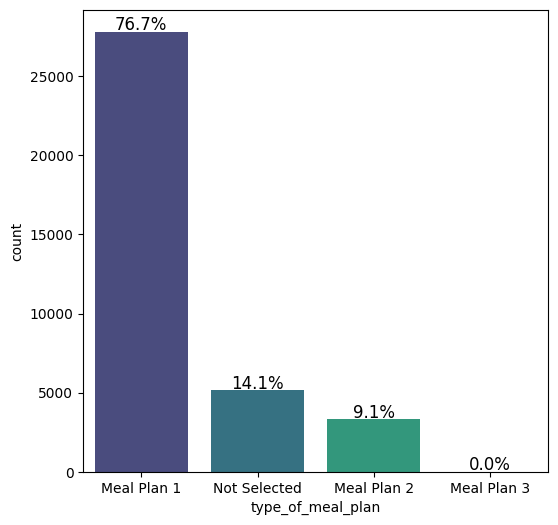

In [ ]:
labeled_barplot(data, "type_of_meal_plan",perc=True)


*  76.7% of bookings have opted for Meal plan 1 ie,Breakfast alone.It appears to be the choice for guests

### **Observations on room type reserved**

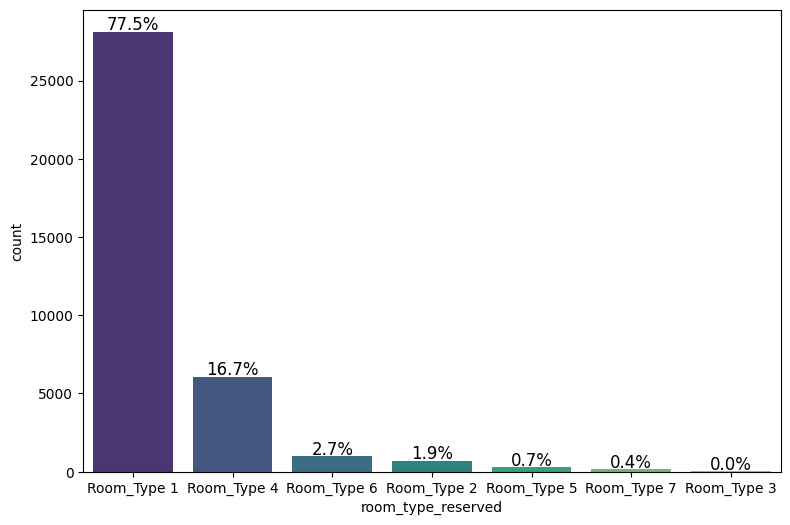

In [ ]:
labeled_barplot(data, "room_type_reserved",perc=True)

*  About 77.5% of the bookings have opted to reserve for Room_Type 1
*Room_type 3 is the least preferred room type reserved

### **Observations on arrival month**

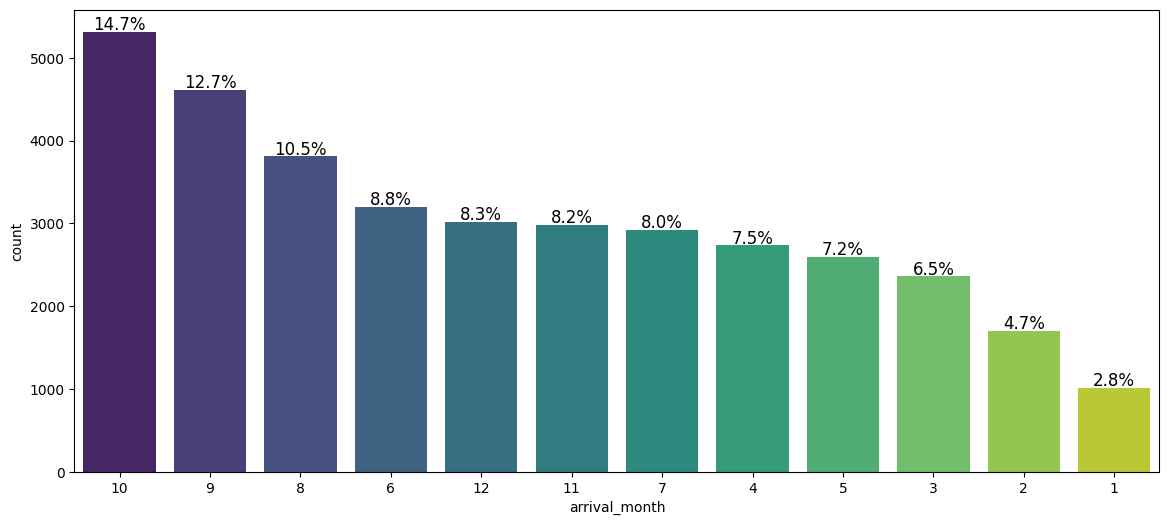

In [ ]:
labeled_barplot(data, "arrival_month",perc=True)

**Plotting arrival month data separately for 2018 and 2017**

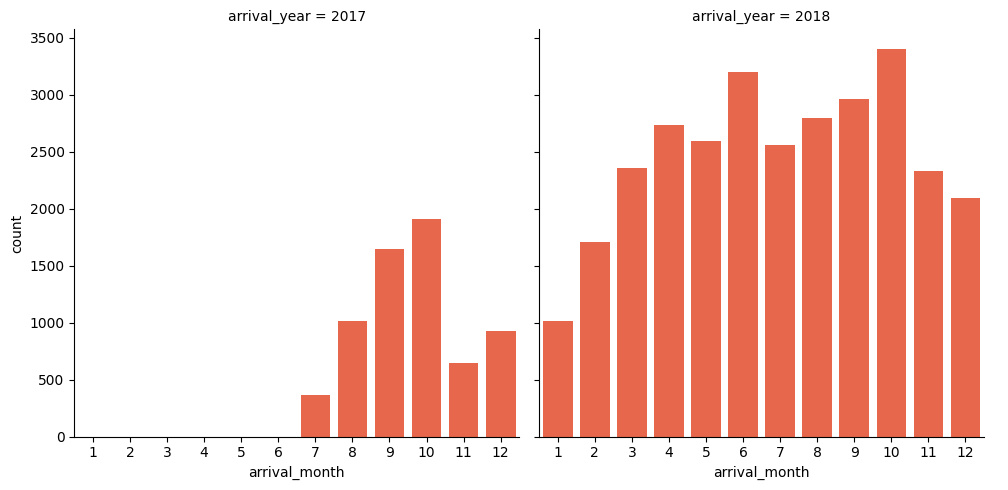

In [ ]:
sns.catplot(data = data, x = 'arrival_month', kind = 'count',col = 'arrival_year',color = "#ff5733")
plt.ylabel('Count')
plt.show()


* For 2017 we only have the data from July
*In 2018,October is the busiest month followed by June
*In 2017,October is the busiest month followed by September
* Number of bookings decreases after October and stays low uptil March
*Almost 14.7% of total bookings was for October followed by September(12.7%) and August(10.5%).
*January and February have the lowest bookings

### **Observations on arrival year**

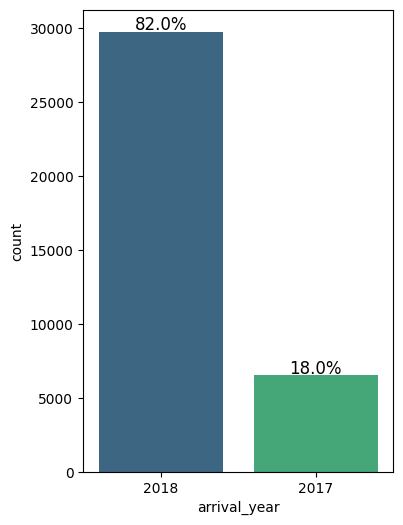

In [ ]:
labeled_barplot(data, "arrival_year",perc=True)

*  82% of the bookings in the dataset occured during 2018.This may be because we don't have the entire data from 2017

### **Observations on arrival date**

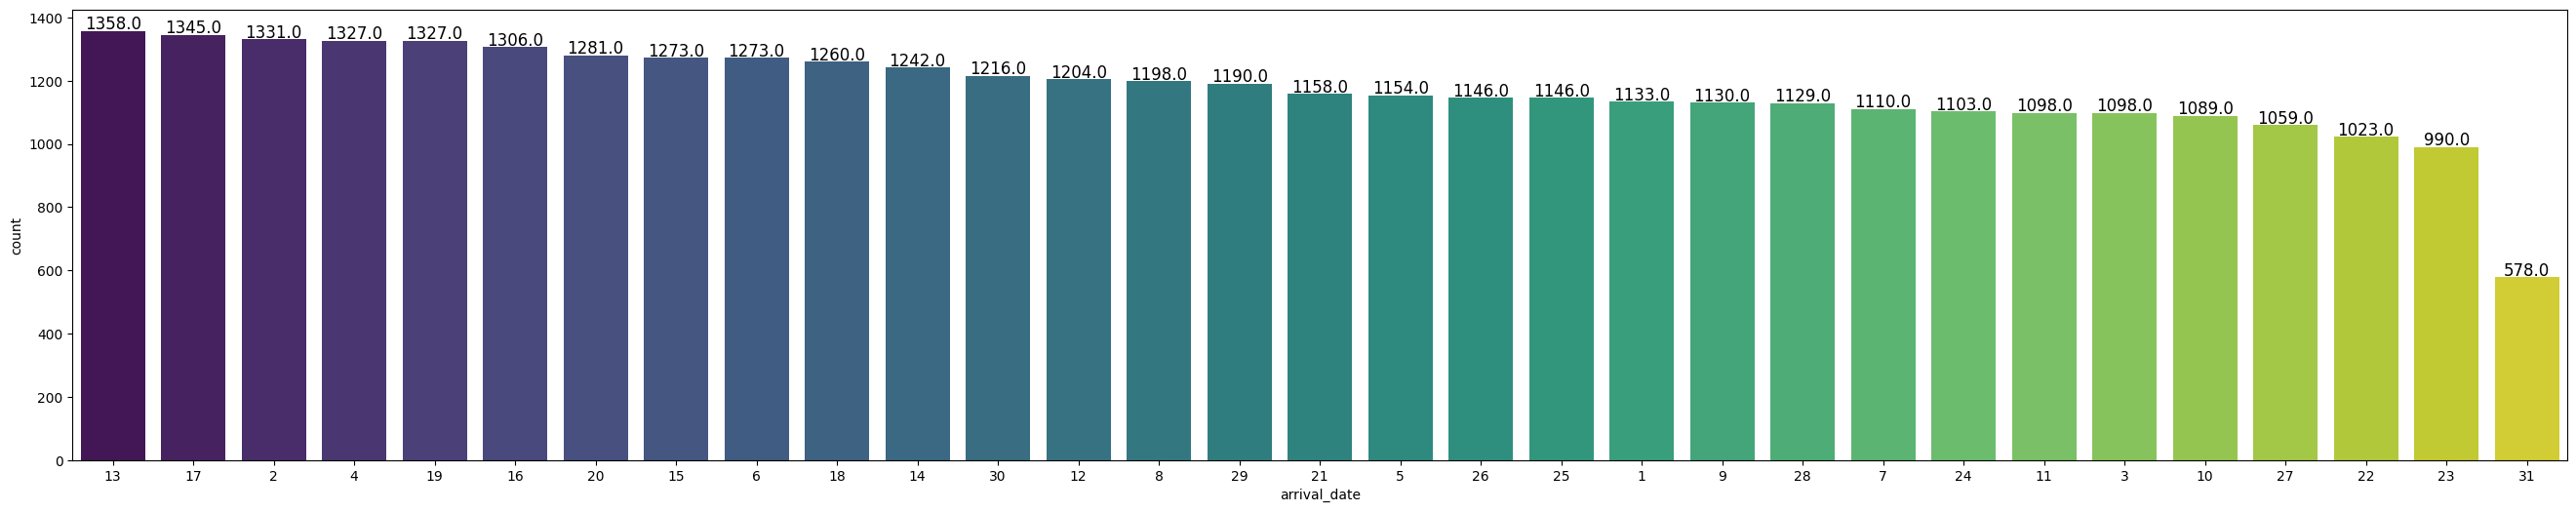

In [ ]:
labeled_barplot(data, "arrival_date")

**Observations:**

* Majority of the bookings were for the dates 13,17,2,4,19,16
*31st has the least number of bookings .This may be due to fact tat all the months don't have 31 days

### **Observations on market_segment_type**

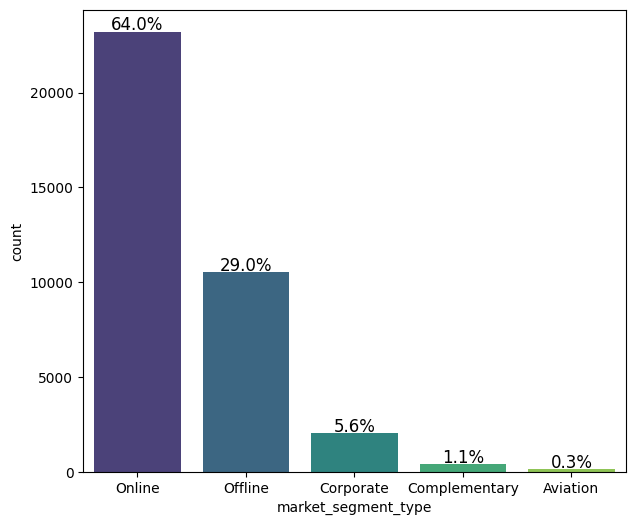

In [ ]:
labeled_barplot(data, "market_segment_type",perc=True)

In [ ]:
data['market_segment_type'].value_counts()

market_segment_type
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: count, dtype: int64

*  Among the different market_segment_type available Online is the most popular with booking choice ( frequency of 23214 - 64%) followed by Offline(29%).

### **Observations on repeated_guest**

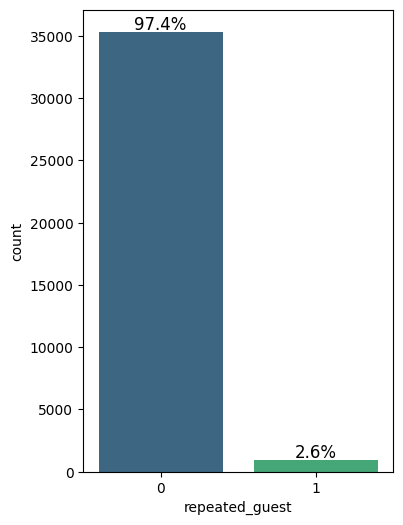

In [ ]:
labeled_barplot(data,"repeated_guest",perc = True)

*  Only 2.6% of bookings were from repeated guests.

### **Observations on no_of_special_requests**

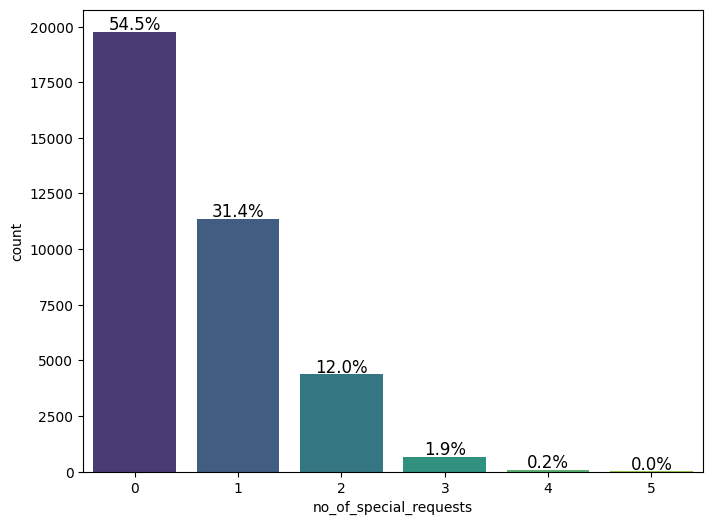

In [ ]:
labeled_barplot(data, "no_of_special_requests",perc=True)

*  In the dataset,  of the total bookings(54.5%) did not hav any special requests
* 31.4% of total bookings had only one special request

### **Observations on booking_status**

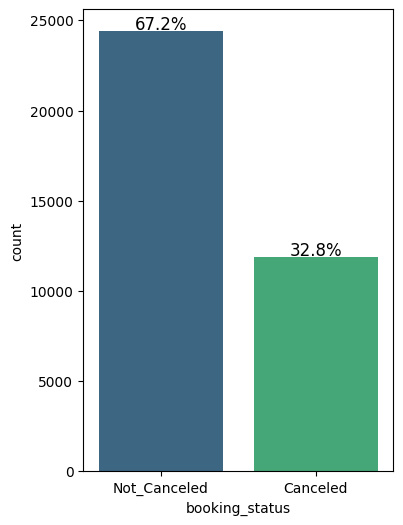

In [ ]:
labeled_barplot(data, "booking_status",perc=True)

*  Of the total bookings 32.8 % were canceled and 67.2% were not canceled

### **Let's encode 'booking _status' values 'Canceled' to 1 and 'Not_Canceled' as 0 for further analysis**

In [ ]:
data["booking_status"] = data["booking_status"].apply(
    lambda x: 1 if x == "Canceled" else 0
)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_segment_

## **Bivariate Analysis**

####**Correlation Check**

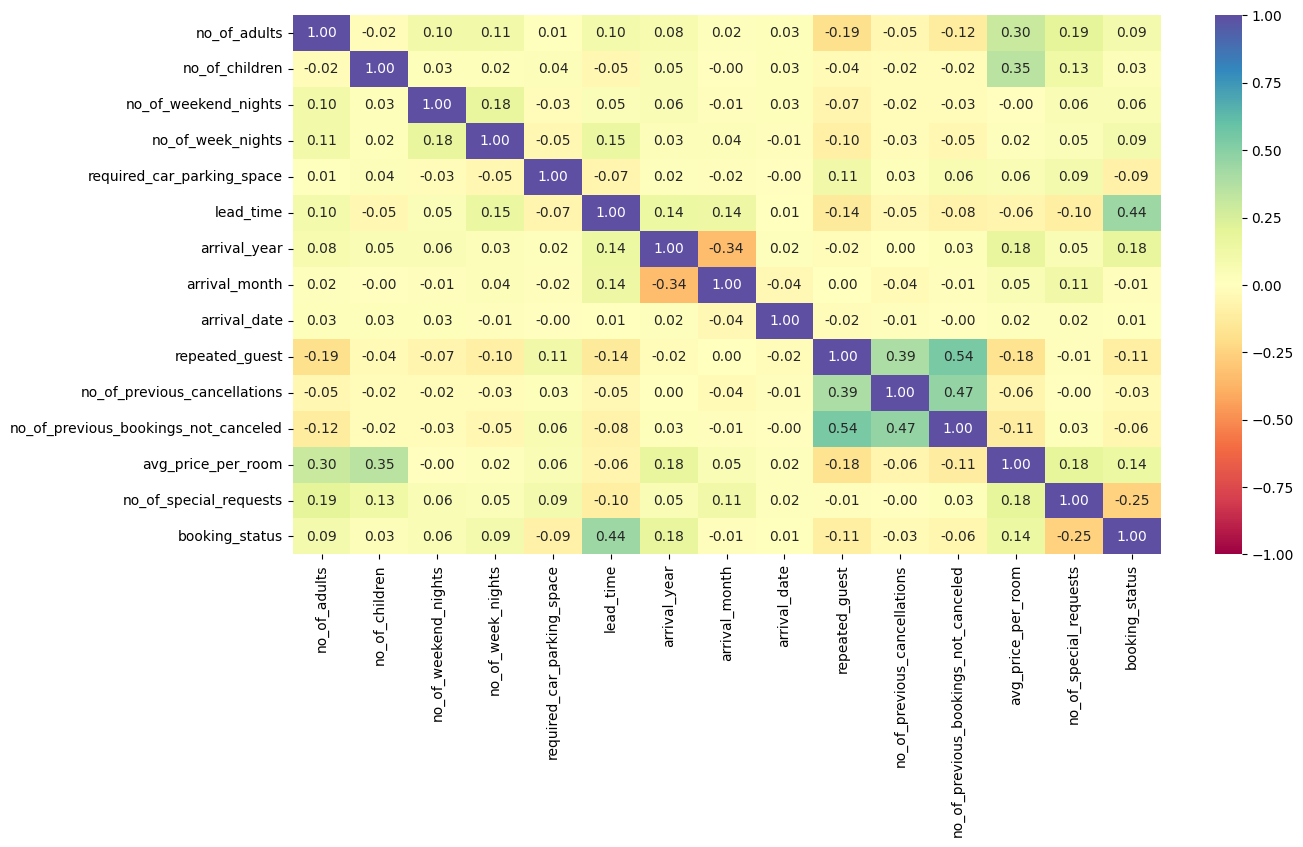

In [ ]:
#heatmap for mumerical values
numeric_columns = data.select_dtypes(include = np.number).columns.tolist()

# correlation heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(
    data[numeric_columns].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap='Spectral'
)
plt.show()

Observations:
* This heatmap shows there is only little correlation between independent variables
*  "no_of_adults" and "avg_price_per_room" have a moderate positive correlation of approximately 0.30. This suggests that as the number of adults increases, the average price per room also tends to increase.
* "no_of_children" and "avg_price_per_room" have a similar moderate positive correlation of around 0.35. This implies that bookings with a higher number of children may be associated with higher average room prices.
* lead_time is shown to be moderately correlated with booking_status.This means as the lead_time increases the chance of booking getting cancelled also increases
* "avg_price_per_room" is shown to be lightly positively correlated with booking_status.This means as the "avg_price_per_room" increases the chance of booking getting cancelled also increases
* The highest correlation is between no_of previous_booking_not cancelled  and repeated_guest

###**market_segment_type** vs **avg_price_per_room**

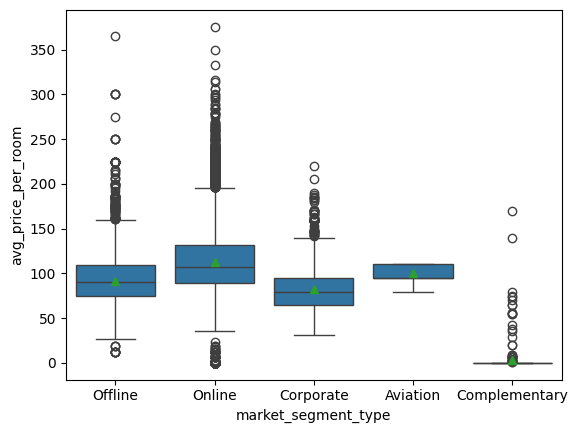

In [ ]:
sns.boxplot(data,x = 'market_segment_type',y  = 'avg_price_per_room',showmeans=True)
plt.show()

Observations:
*  Online bookings appear to have the highest Average Price per room

###**market_segment_type vs booking status**

booking_status           0      1    All
market_segment_type                     
All                  24390  11885  36275
Online               14739   8475  23214
Offline               7375   3153  10528
Corporate             1797    220   2017
Aviation                88     37    125
Complementary          391      0    391
------------------------------------------------------------------------------------------------------------------------


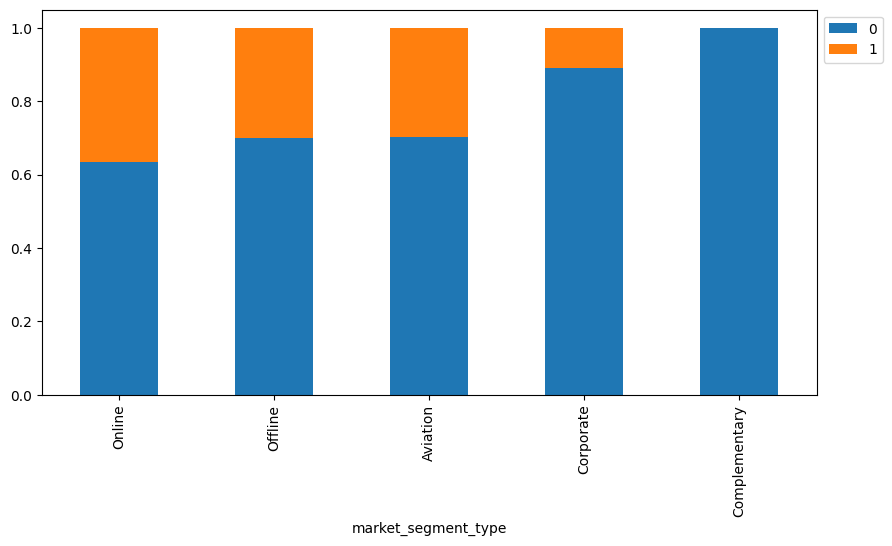

In [ ]:
stacked_barplot(data, "market_segment_type", "booking_status")

*  We have encoded booking_status = Cancelled as 1.So from the above plot we can infer that most no of cancellations occured for Online bookings.
* Complimentary bookings had 0 cancellation

###**Many guests have special requirements when booking a hotel room. Let's see how it impacts cancellations**

booking_status              0      1    All
no_of_special_requests                     
All                     24390  11885  36275
0                       11232   8545  19777
1                        8670   2703  11373
2                        3727    637   4364
3                         675      0    675
4                          78      0     78
5                           8      0      8
------------------------------------------------------------------------------------------------------------------------


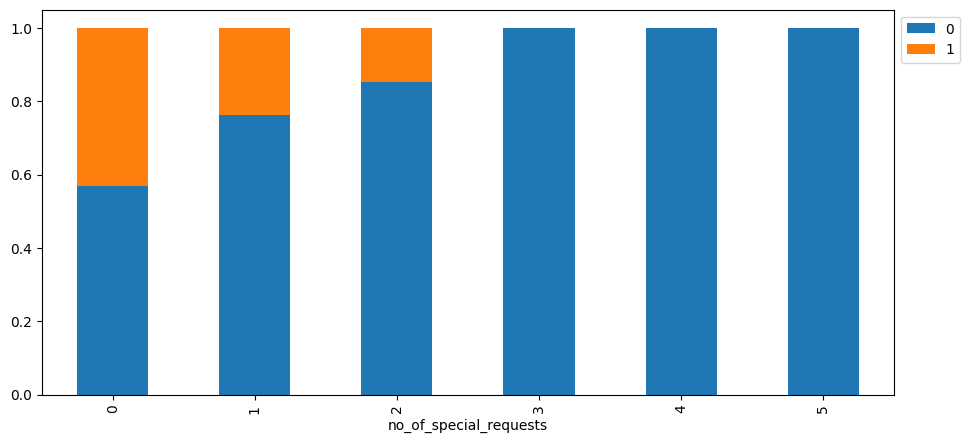

In [ ]:
stacked_barplot(data, "no_of_special_requests", "booking_status")


*  It has been observed that the bookings made with special requests are less likely to be cancelled.
*For bookings made with special requests above 3 there is no cancellation.

###**Let's check the cancelation rates among repeat customers**

booking_status      0      1    All
repeated_guest                     
All             24390  11885  36275
0               23476  11869  35345
1                 914     16    930
------------------------------------------------------------------------------------------------------------------------


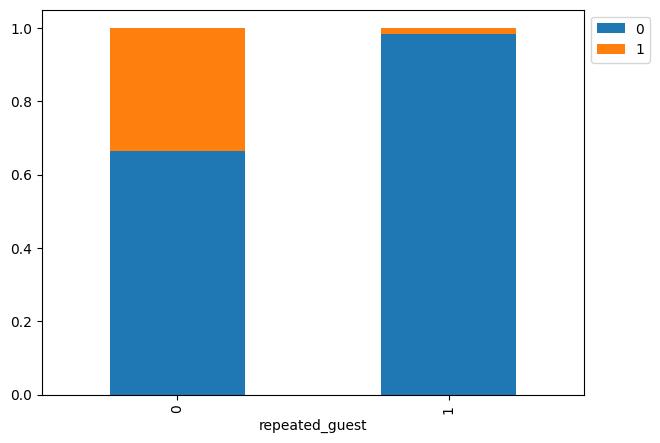

In [ ]:
stacked_barplot(data, "repeated_guest", "booking_status")

**Observations:**

* Among bookings with repeated guests:

  * 98.3% of reservations were not canceled (914)
 * 1.7% of reservations were canceled (16)

Among bookings with no repeated guests:

* 66.5% of reservations were not canceled (23476).
* 33.5% of reservations were canceled (11869).

*Cancellation rate for bookings made by repeated guests is very low(1.7%)

###**no_of_special_requests** vs **avg_price_per_room**

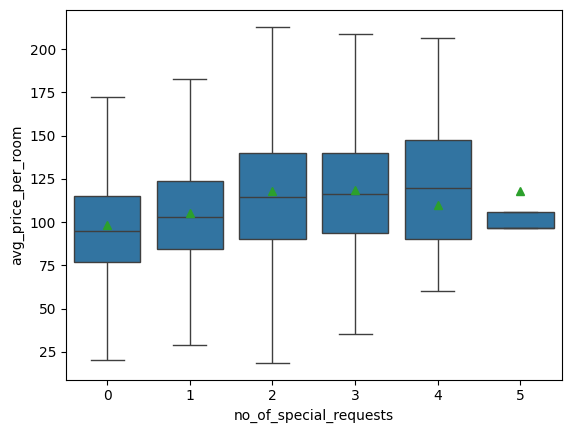

In [ ]:
sns.boxplot(data,x = 'no_of_special_requests',y  = 'avg_price_per_room',showmeans=True,showfliers = False)
plt.show()

* In majority of the cases Average price of the room is shown to increase with the no_of_special_requests

### **average_price_per_room vs booking_status**

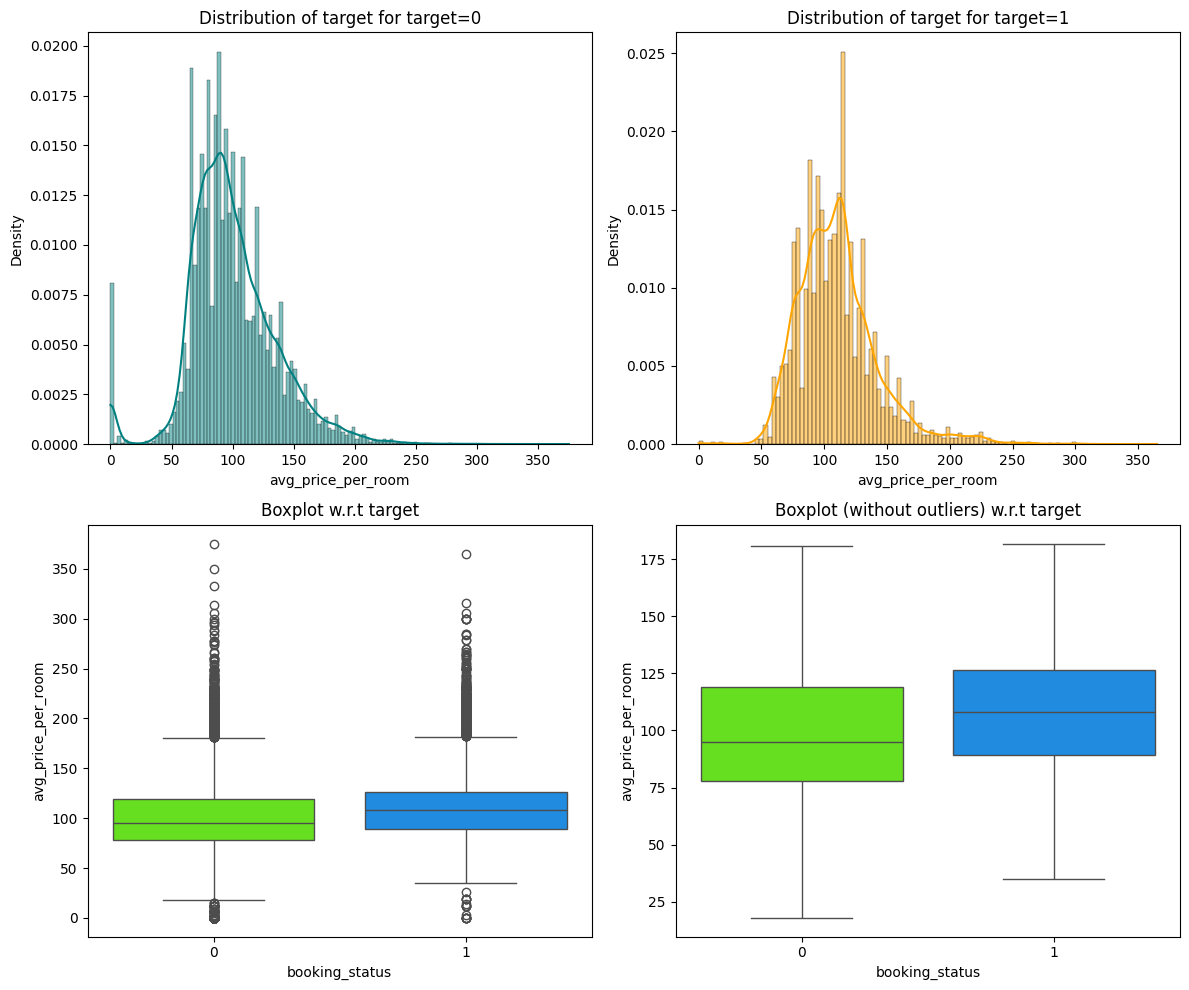

In [ ]:
# Comparitive distribution of average price per room and booking status
distribution_plot_wrt_target(data, "avg_price_per_room", "booking_status")

Observations:
*  Rooms with higher average_price_per_room seem to have a higher chance of getting cancelled

###**Lets analyse the relation between the lead_time and booking status in detail**

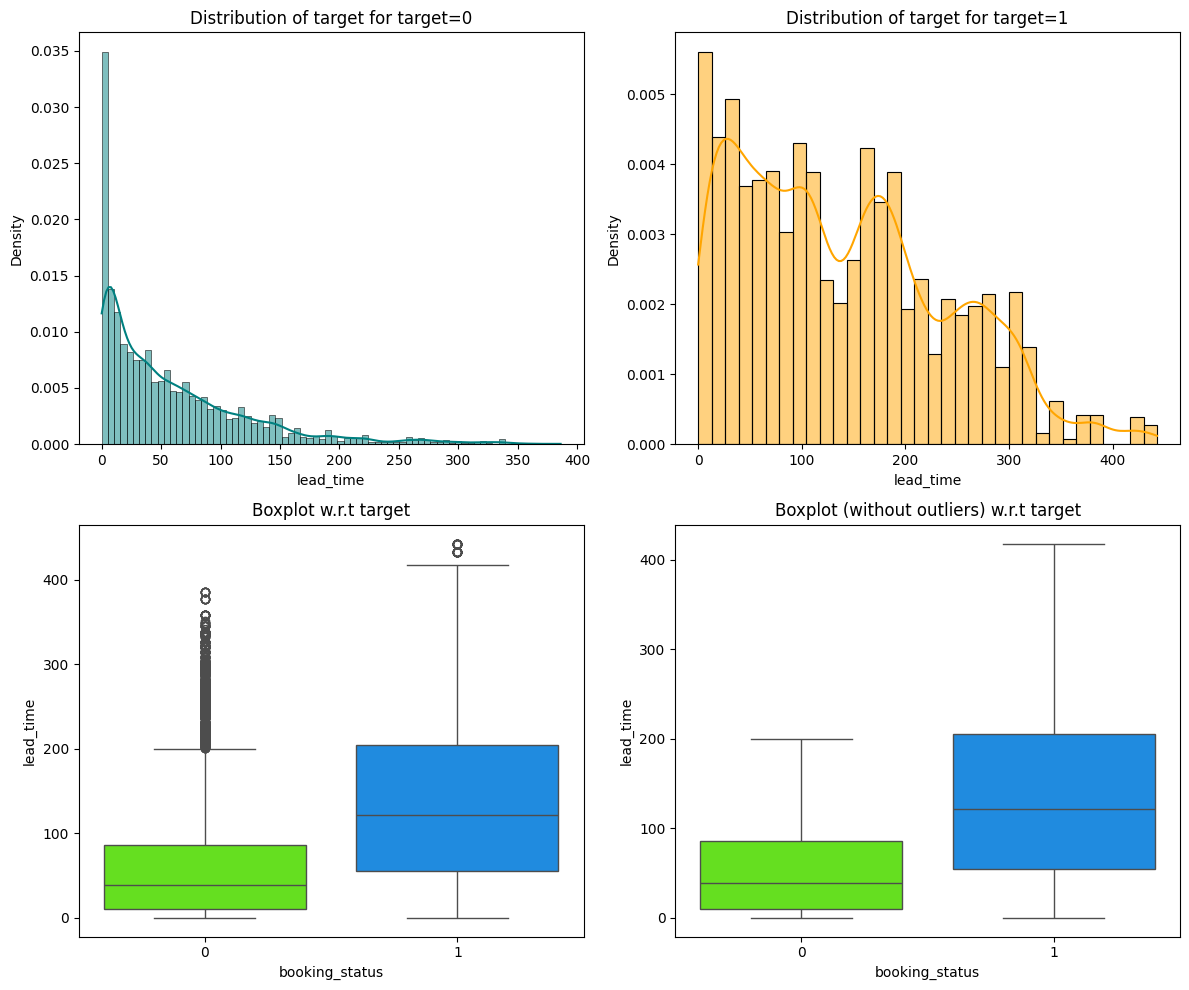

In [ ]:
# Comparitive distribution of lead time and booking status
distribution_plot_wrt_target(data, "lead_time", "booking_status")

Observations:
*  As seen from the heatmap,lead_time is positively correlated with booking_status
* As the lead_time(number of days between the date of booking and the arrival date) increases the chance of the booking getting cancelled also increases

###**Let's see how the number of adults and children impacts the prices of a room**

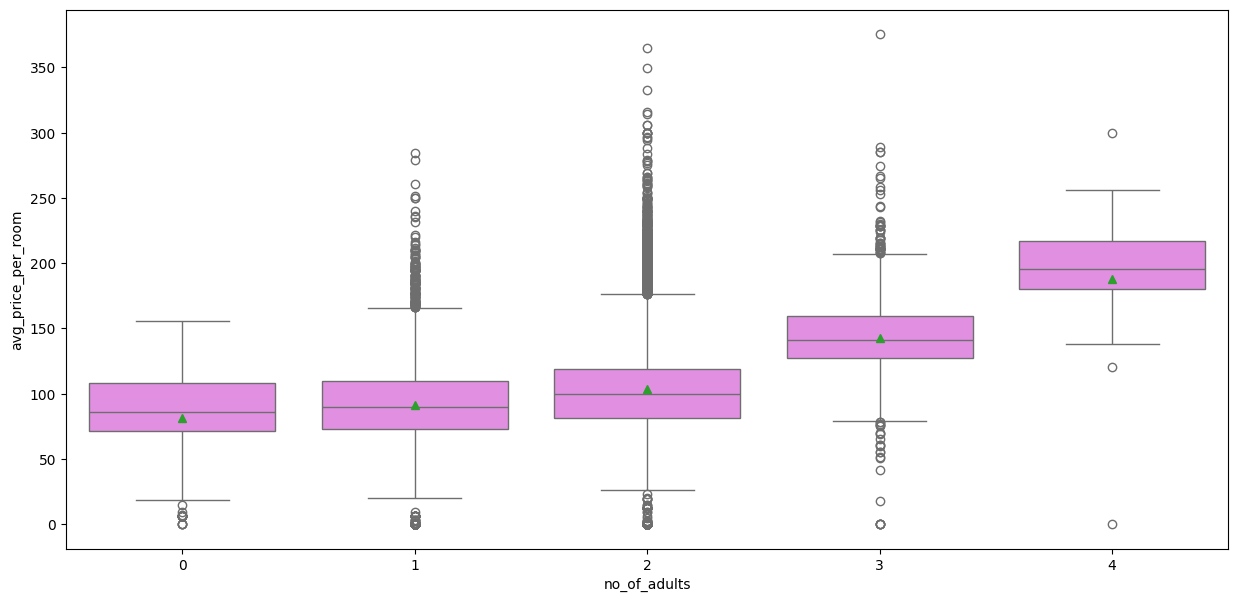

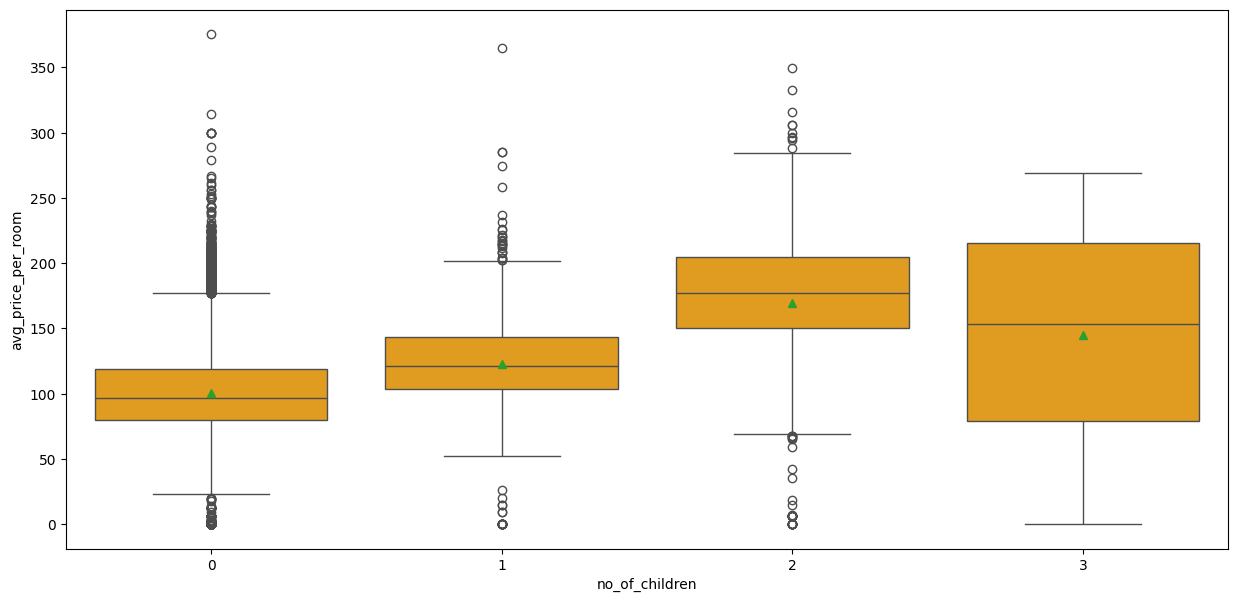

In [ ]:
plt.figure(figsize=(15, 7))
sns.boxplot(data,x = 'no_of_adults',y  = 'avg_price_per_room',showmeans=True,color = 'violet')
plt.show()

plt.figure(figsize=(15, 7))
sns.boxplot(data,x = 'no_of_children',y  = 'avg_price_per_room',showmeans=True,color = 'orange')
plt.show()

*  In both the cases the as the number of adults and children increase the average price of the room increases

###**Let's see how the number of adults and children impacts the booking status**

booking_status      0      1    All
no_of_adults                       
All             24390  11885  36275
2               16989   9119  26108
1                5839   1856   7695
3                1454    863   2317
0                  95     44    139
4                  13      3     16
------------------------------------------------------------------------------------------------------------------------


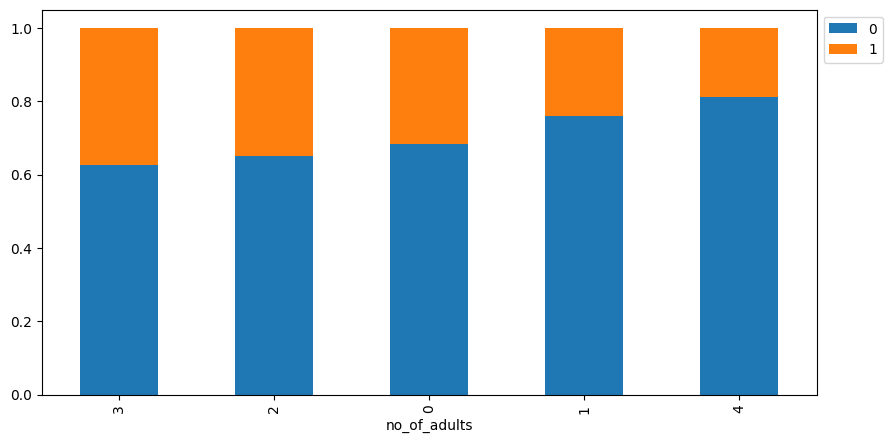

In [ ]:
stacked_barplot(data, "no_of_adults", "booking_status")

**Observations:**
* Bookings made with 4 adults had the lowest cancellation rate of 18.7%,followed by bookings with 1 adult(24.1%)

booking_status      0      1    All
no_of_children                     
All             24390  11885  36275
0               22695  10882  33577
1                1078    540   1618
2                 601    457   1058
3                  16      6     22
------------------------------------------------------------------------------------------------------------------------


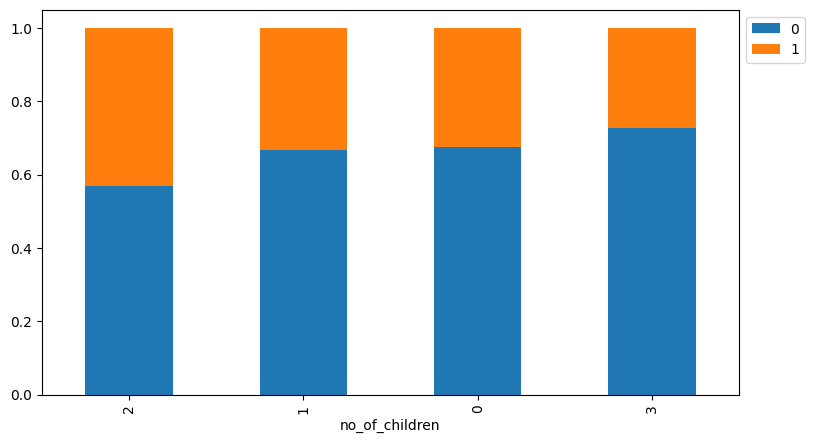

In [ ]:
stacked_barplot(data, "no_of_children", "booking_status")

**Observations:**
* Bookings made with 3 children had the lowest cancellation rate of 27.27%,followed by bookings with no children(32.4%)

###**Lets us see how booking status is affected with respect to group size of each booking**


In [ ]:
# Create a new dataset for total number of guests per booking
group_size = data[(data["no_of_adults"] >=0) | (data["no_of_children"]) >=0]

group_size["no_of_individuals"] = data["no_of_adults"] + data["no_of_children"]
group_size['booking_status'] = data['booking_status']


booking_status         0      1    All
no_of_individuals                     
All                24390  11885  36275
2                  15662   8280  23942
1                   5743   1809   7552
3                   2459   1392   3851
4                    515    398    913
5                     11      6     17
------------------------------------------------------------------------------------------------------------------------


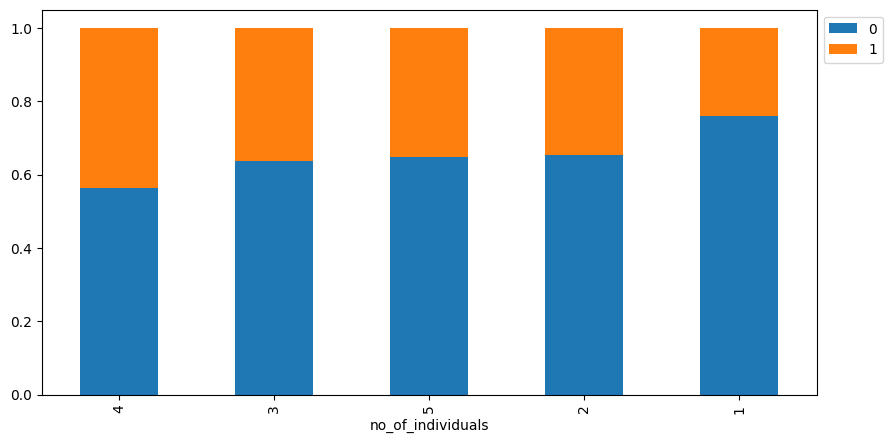

In [ ]:
# Stacked barplot for booking status and group size
stacked_barplot(group_size, "no_of_individuals", "booking_status")

Observations:
*  The least cancellation rate was for bookings with total individual size 1.It was 34.6%
*Followed by total size of 2(34.6%) and 3(36.1%)

###**As hotel room prices are dynamic, Let's see how the prices vary across different months and years**

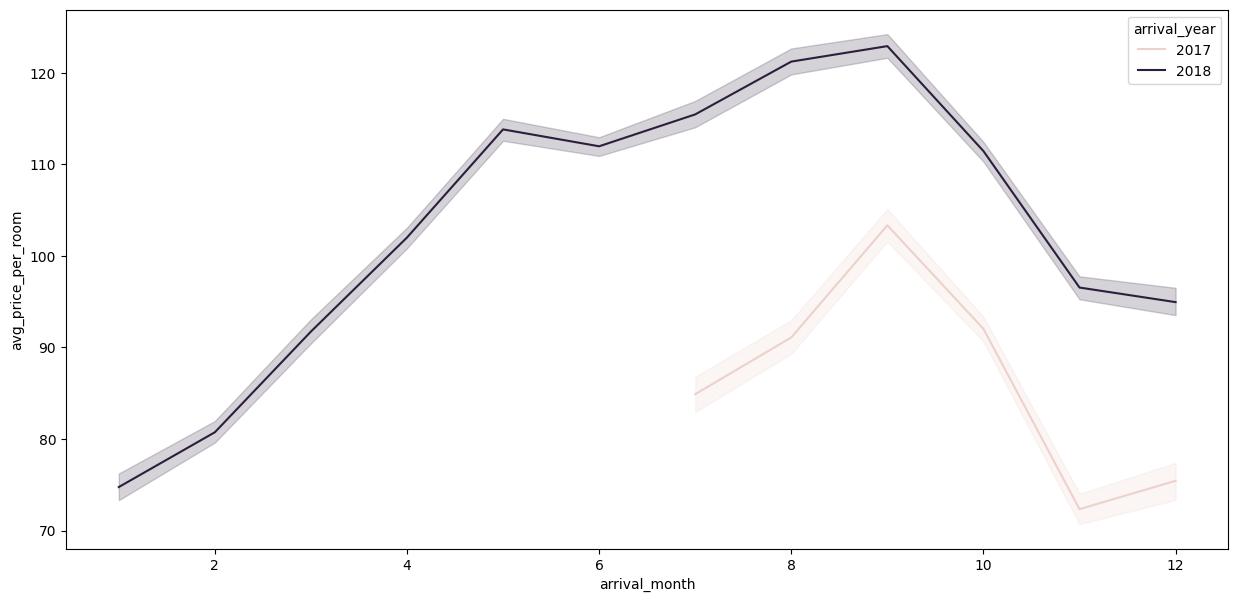

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data,x= 'arrival_month',y  = 'avg_price_per_room',hue = 'arrival_year')
plt.show()


**Observations:**
*  Prices in 2018 appear slightly higher than those in 2017 for most months.
*In both 2017 and 2018 ,avg_price_per_room is highest in the month of September
*The price trends for both years follow a similar pattern.
*But data for some months in 2017 is missing
* Average price per room increases steadily from the beginning of the year peaking around September and drop after that

###**Does the requirement of car parking space increases the price of the room**

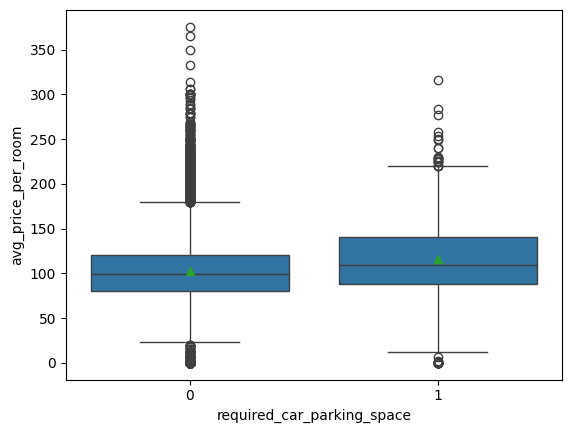

In [ ]:
sns.boxplot(data,x = 'required_car_parking_space',y  = 'avg_price_per_room',showmeans=True)
plt.show()

Observations:
*  Average price of the room with  a car parking space is higher
* This may be reason 97% of bookings do not prefer a parking spot

### **required_car_parking_space vs booking status**

booking_status                  0      1    All
required_car_parking_space                     
All                         24390  11885  36275
0                           23380  11771  35151
1                            1010    114   1124
------------------------------------------------------------------------------------------------------------------------


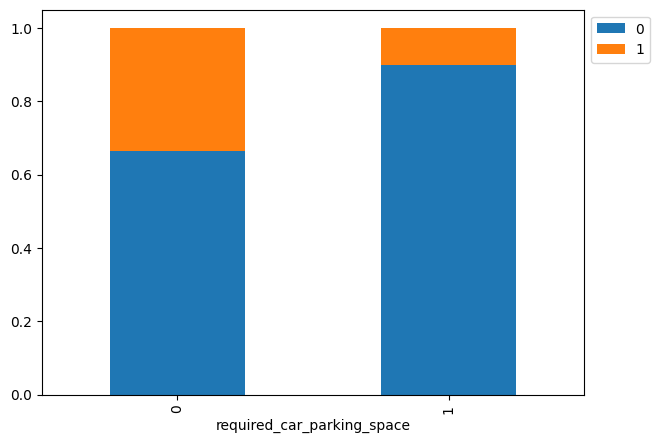

In [ ]:
stacked_barplot(data, "required_car_parking_space", "booking_status")

*  Bookings made by guests who required car parking space had lesser cancellations

###**Is there a huge difference in the price of the room with respect to type_of_meal_plan_selected??**

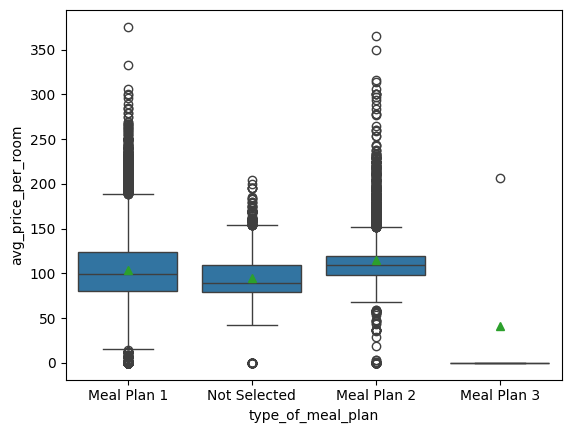

In [ ]:
sns.boxplot(data,x = 'type_of_meal_plan',y  = 'avg_price_per_room',showmeans=True)
plt.show()

Observations:
*  From the plot it can be seen that avg_price_per_room changes with the type of meal plan selected.
* avg_price_per room is least for 'Not Selected'(No meal plan selected)

###**Is the booking status influenced by the number of week nights reserved?**

booking_status         0      1    All
no_of_week_nights                     
All                24390  11885  36275
2                   7447   3997  11444
3                   5265   2574   7839
1                   6916   2572   9488
4                   1847   1143   2990
0                   1708    679   2387
5                    982    632   1614
6                    101     88    189
10                     9     53     62
7                     61     52    113
8                     30     32     62
9                     13     21     34
11                     3     14     17
15                     2      8     10
12                     2      7      9
13                     0      5      5
14                     3      4      7
16                     0      2      2
17                     1      2      3
------------------------------------------------------------------------------------------------------------------------


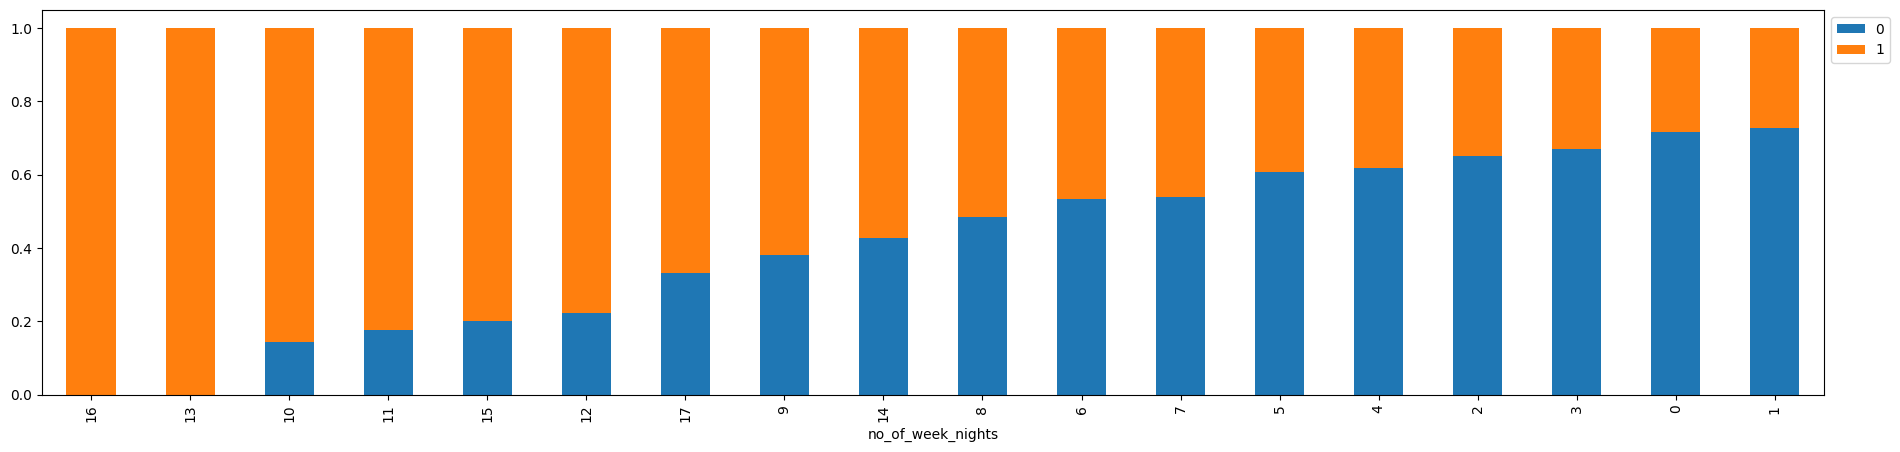

In [ ]:
stacked_barplot(data, "no_of_week_nights", "booking_status")

Observations:

*  As the number of week_nights booked increase,the chance of booking getting cancelled also increase
* The least cancellation rate was for bookings with one week_night(27.1 %)

###**Is the booking status influenced by the number of weekend nights reserved?**

booking_status            0      1    All
no_of_weekend_nights                     
All                   24390  11885  36275
0                     11779   5093  16872
1                      6563   3432   9995
2                      5914   3157   9071
4                        46     83    129
3                        79     74    153
5                         5     29     34
6                         4     16     20
7                         0      1      1
------------------------------------------------------------------------------------------------------------------------


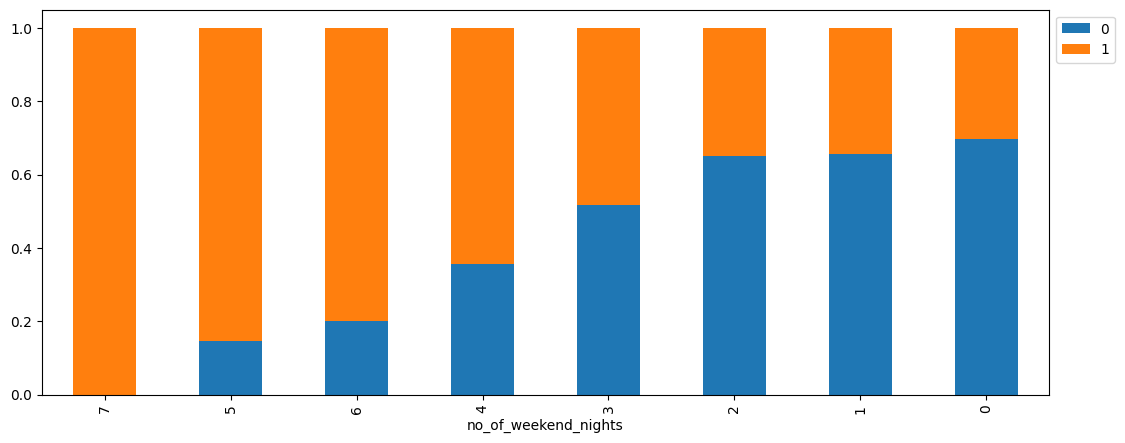

In [ ]:
stacked_barplot(data, "no_of_weekend_nights", "booking_status")

Observations:

*  As the number of weekend_nights booked increases,the chance of booking getting cancelled also increases
*The least cancellation rate was for bookings with 0 weekend_nights(30.18 %),followed by bookings with 1 weekend night(34.3%)

#### **Total days vs Booking status**

In [ ]:
# Create a new dataset for total length of stay per booking
length_of_stay = data[(data["no_of_week_nights"] > 0) | (data["no_of_weekend_nights"] > 0)] #filtering per no of night >0

In [ ]:
length_of_stay["total_days"] = (length_of_stay["no_of_week_nights"] + length_of_stay["no_of_weekend_nights"]) #creating new column

booking_status      0      1    All
total_days                         
All             24314  11883  36197
3                6466   3586  10052
2                5573   2899   8472
4                3952   1941   5893
1                5138   1466   6604
5                1766    823   2589
6                 566    465   1031
7                 590    383    973
8                 100     79    179
10                 51     58    109
9                  58     53    111
14                  5     27     32
15                  5     26     31
13                  3     15     18
12                  9     15     24
11                 24     15     39
20                  3      8     11
19                  1      5      6
16                  1      5      6
17                  1      4      5
18                  0      3      3
21                  1      3      4
22                  0      2      2
23                  1      1      2
24                  0      1      1
----------------------------

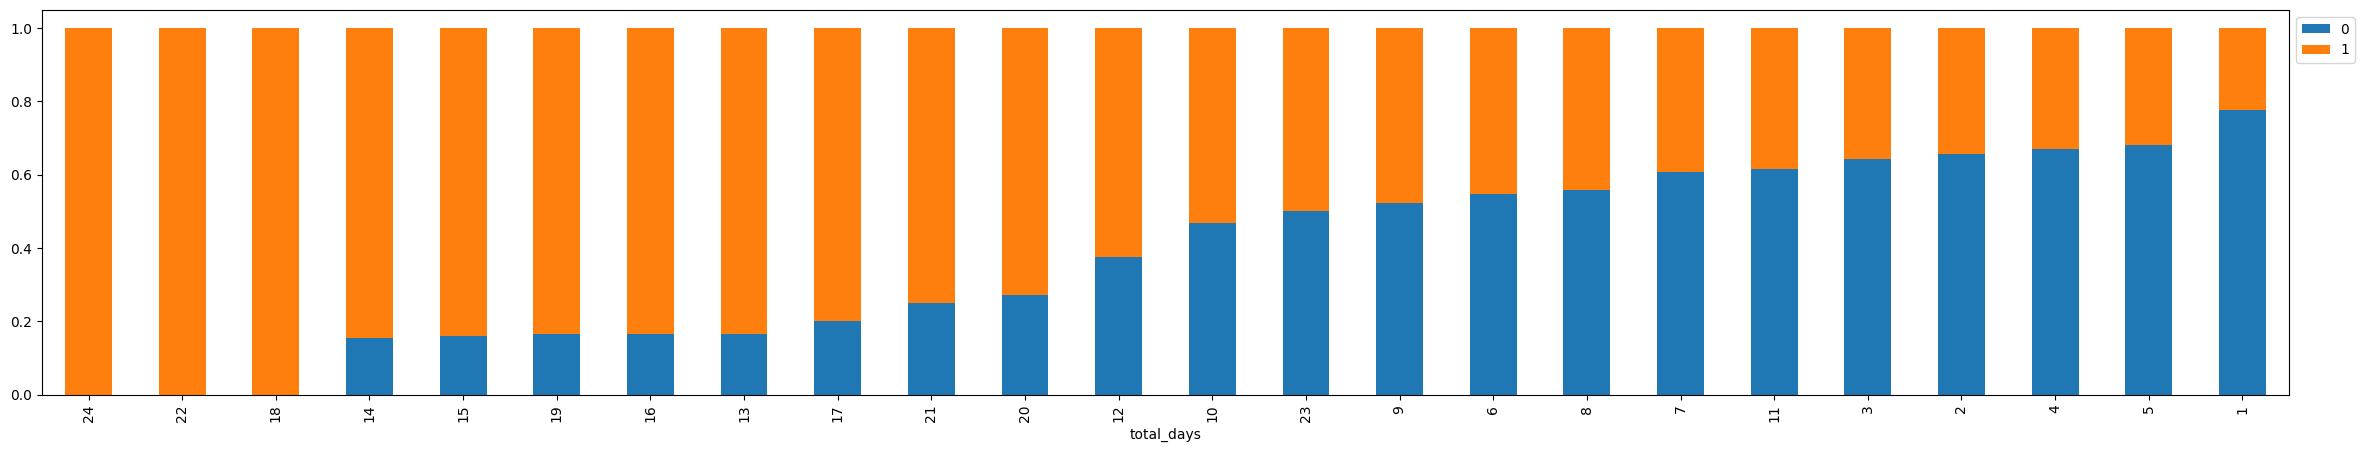

In [ ]:
stacked_barplot(length_of_stay,"total_days","booking_status")


**Observations:**
*  Majority of bookings was for 3 days,followed by 2 days
* Bookings made for 1 day had the least cancellations(22.2% cancellations)

#### **room_type_reserved vs booking_status**

booking_status          0      1    All
room_type_reserved                     
All                 24390  11885  36275
Room_Type 1         19058   9072  28130
Room_Type 4          3988   2069   6057
Room_Type 6           560    406    966
Room_Type 2           464    228    692
Room_Type 5           193     72    265
Room_Type 7           122     36    158
Room_Type 3             5      2      7
------------------------------------------------------------------------------------------------------------------------


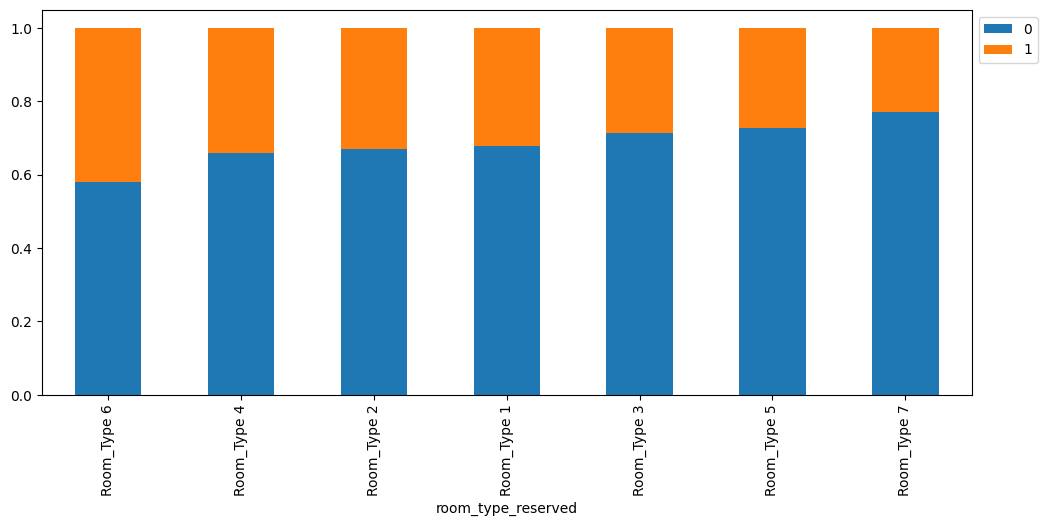

In [ ]:
stacked_barplot(data, "room_type_reserved", "booking_status")

**Observations:**

*  Cancellations were highest for bookings with 'Room_Type 6' reserved
*  Cancellations were lowest for bookings with 'Room_Type 7' reserved

### **Let us analyze the booking status across different months and years**

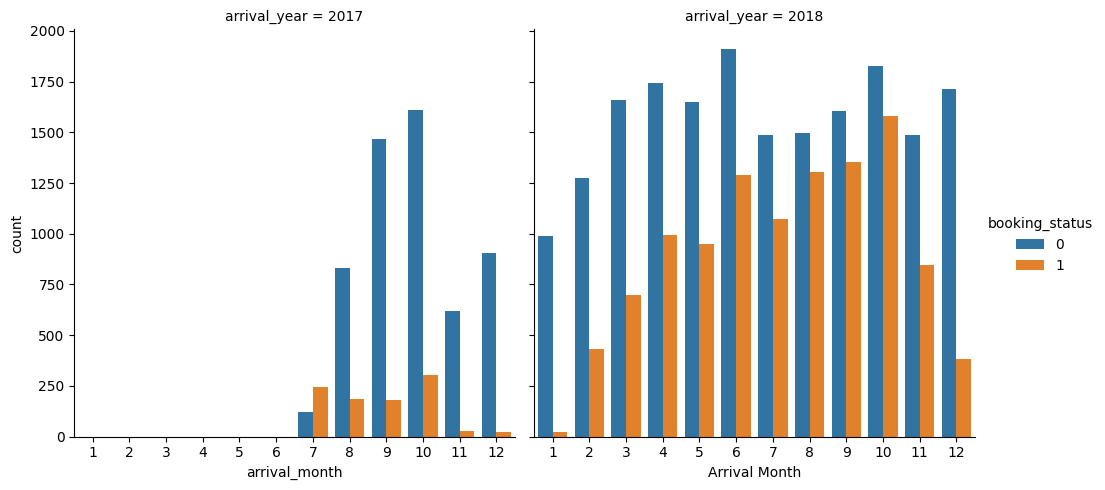

In [ ]:
sns.catplot(data = data, x = 'arrival_month', hue = 'booking_status', kind = 'count',col = 'arrival_year')
plt.xlabel('Arrival Month')
plt.ylabel('Count')
plt.show()

Observations:

In 2018
* Least number of booking cancellations was in January.
* October which had the largest bookings but had the most cancellations too

In 2017
*  Least number of booking cancellations were in December and November
*October had the highest number of bookings and the highest cancellation number too



* For the same months,no of cancellations has increased from 2017 to 2018

In [ ]:
sns.pairplot(data, hue="booking_status")

Output hidden; open in https://colab.research.google.com to view.

## Data Preprocessing

- Missing value treatment (if needed)
- Feature engineering (if needed)
- Outlier detection and treatment (if needed)
- Preparing data for modeling
- Any other preprocessing steps (if needed)

### Missing Value Treatment

In [ ]:
#checking for missing values
data.isnull().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

**Observation:**
*   There are no missing values in the dataset

### Featured Engineering


* We previously treated some data while performing EDA
   * Booking_ID was dropped from the dataframe
   *  The upper level outliers in avg_price_per_room that had values greater than or equal to $500 were treated and replaced with the upper whisker price of  179.55 dollar
   * There were some outliers in the number of children-bookings with 9 or10 children were replaced with 3
   *Encoded booking status:Non Canceled = 0 and Canceled = 1

### Outlier Check

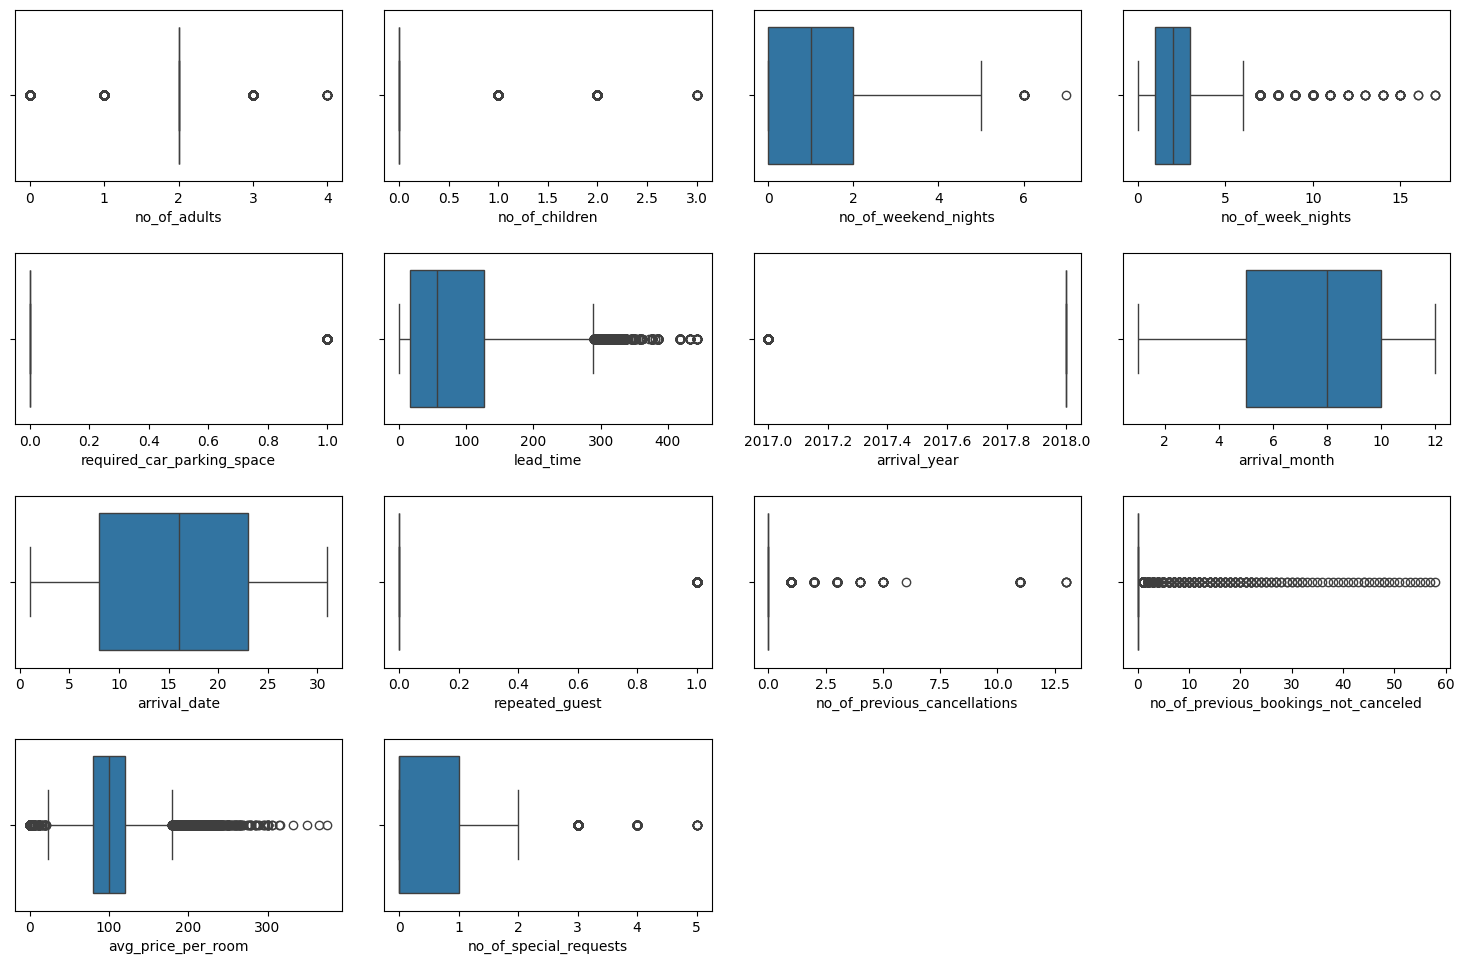

In [ ]:
num_cols = data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 10))

if "booking_status" in num_cols:
    num_cols.remove("booking_status")

for i, variable in enumerate(num_cols):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(data, x=variable)
    plt.tight_layout(pad=2)

plt.show()

**Observations:**
- There are some outliers in the data , but they will not be treated since they are proper values

### Data Preparation for modeling

*  We have already encoded 'booking _status' values 'Canceled' to 1 and 'Not_Canceled' as 0 ,as the hotel wants to identify those customers predicted to cancel their booking
*We want to predict which bookings will be canceled.
*Before we proceed to build a model, we'll have to encode categorical features
*We'll split the data into train and test to be able to evaluate the model that we build on the train data

In [ ]:
X = data.drop("booking_status", axis=1)
Y = data["booking_status"]

# let's add the intercept to data
X = sm.add_constant(X)

# creating dummy variables
X = pd.get_dummies( X,drop_first=True)

X.head()

const  no_of_adults  no_of_children  no_of_weekend_nights  \
0   1.00             2               0                     1   
1   1.00             2               0                     2   
2   1.00             1               0                     2   
3   1.00             2               0                     0   
4   1.00             2               0                     1   

   no_of_week_nights  required_car_parking_space  lead_time  arrival_year  \
0                  2                           0        224          2017   
1                  3                           0          5          2018   
2                  1                           0          1          2018   
3                  2                           0        211          2018   
4                  1                           0         48          2018   

   arrival_month  arrival_date  repeated_guest  no_of_previous_cancellations  \
0             10             2               0                             0   
1             11             6               0                             0   
2              2            28               0                             0   
3              5            20               0                             0   
4              4            11               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests  type_of_meal_plan_Meal Plan 2  \
0                       0                          False   
1                       1                          False   
2                       0                          False   
3                       0                          False   
4                       0                          False   

   type_of_meal_plan_Meal Plan 3  type_of_meal_plan_Not Selected  \
0                          False                           False   
1                          False                            True   
2                          False                           False   
3                          False                           False   
4                          False                            True   

   room_type_reserved_Room_Type 2  room_type_reserved_Room_Type 3  \
0                           False                           False   
1                           False                           False   
2                           False                           False   
3                           False                           False   
4                           False                           False   

   room_type_reserved_Room_Type 4  room_type_reserved_Room_Type 5  \
0                           False                           False   
1                           False                           False   
2                           False                           False   
3                           False                           False   
4                           False                           False   

   room_type_reserved_Room_Type 6  room_type_reserved_Room_Type 7  \
0                           False                           False   
1                           False                           False   
2                           False                           False   
3                           False                           False   
4                           False                           False   

   market_segment_type_Complementary  market_segment_type_Corporate  \
0                              False                          False   
1                              False                          False   
2                              False                          False

In [ ]:
# converting the input attributes into float type for modeling
X = X.astype(float)
X.head()

const  no_of_adults  no_of_children  no_of_weekend_nights  \
0   1.00          2.00            0.00                  1.00   
1   1.00          2.00            0.00                  2.00   
2   1.00          1.00            0.00                  2.00   
3   1.00          2.00            0.00                  0.00   
4   1.00          2.00            0.00                  1.00   

   no_of_week_nights  required_car_parking_space  lead_time  arrival_year  \
0               2.00                        0.00     224.00       2017.00   
1               3.00                        0.00       5.00       2018.00   
2               1.00                        0.00       1.00       2018.00   
3               2.00                        0.00     211.00       2018.00   
4               1.00                        0.00      48.00       2018.00   

   arrival_month  arrival_date  repeated_guest  no_of_previous_cancellations  \
0          10.00          2.00            0.00                          0.00   
1          11.00          6.00            0.00                          0.00   
2           2.00         28.00            0.00                          0.00   
3           5.00         20.00            0.00                          0.00   
4           4.00         11.00            0.00                          0.00   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                  0.00               65.00   
1                                  0.00              106.68   
2                                  0.00               60.00   
3                                  0.00              100.00   
4                                  0.00               94.50   

   no_of_special_requests  type_of_meal_plan_Meal Plan 2  \
0                    0.00                           0.00   
1                    1.00                           0.00   
2                    0.00                           0.00   
3                    0.00                           0.00   
4                    0.00                           0.00   

   type_of_meal_plan_Meal Plan 3  type_of_meal_plan_Not Selected  \
0                           0.00                            0.00   
1                           0.00                            1.00   
2                           0.00                            0.00   
3                           0.00                            0.00   
4                           0.00                            1.00   

   room_type_reserved_Room_Type 2  room_type_reserved_Room_Type 3  \
0                            0.00                            0.00   
1                            0.00                            0.00   
2                            0.00                            0.00   
3                            0.00                            0.00   
4                            0.00                            0.00   

   room_type_reserved_Room_Type 4  room_type_reserved_Room_Type 5  \
0                            0.00                            0.00   
1                            0.00                            0.00   
2                            0.00                            0.00   
3                            0.00                            0.00   
4                            0.00                            0.00   

   room_type_reserved_Room_Type 6  room_type_reserved_Room_Type 7  \
0                            0.00                            0.00   
1                            0.00                            0.00   
2                            0.00                            0.00   
3                            0.00                            0.00   
4                            0.00                            0.00   

   market_segment_type_Complementary  market_segment_type_Corporate  \
0                               0.00                           0.00   
1                               0.00                           0.00   
2                               0.00                           0.00

#### Splitting data into train and test

In [ ]:
# splitting the data in 70:30 ratio for train to test data

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [ ]:
print("Number of rows in train data =", x_train.shape[0])
print("Number of rows in test data =", x_test.shape[0])
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Number of rows in train data = 25392
Number of rows in test data = 10883
Percentage of classes in training set:
booking_status
0   0.67
1   0.33
Name: proportion, dtype: float64
Percentage of classes in test set:
booking_status
0   0.68
1   0.32
Name: proportion, dtype: float64


## Model evaluation criterion

### Model can make wrong predictions as:

1. Predicting a customer will not cancel their booking but in reality, the customer will cancel their booking.
2. Predicting a customer will cancel their booking but in reality, the customer will not cancel their booking.

### Which case is more important?
* Both the cases are important as:

* If we predict that a booking will not be canceled and the booking gets canceled then the hotel will lose resources and will have to bear additional costs of distribution channels.

* If we predict that a booking will get canceled and the booking doesn't get canceled the hotel might not be able to provide satisfactory services to the customer by assuming that this booking will be canceled. This might damage the brand equity.



### How to reduce the losses?

* Hotel would want `F1 Score` to be maximized, greater the F1  score higher are the chances of minimizing False Negatives and False Positives.

#### We have already created functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
* The model_performance_classification_statsmodels function will be used to check the model performance of models.
* The confusion_matrix_statsmodels function will be used to plot the confusion matrix.

## Fitting  Logistic Regression Model

* Since the training set has 67% Class 0 and 33% Class 1, the dataset is imbalanced.

* In this case, we will set class_weight = "balanced", which will automatically adjust the weights to be inversely proportional to the class frequencies in the input data

In [ ]:
logit = sm.Logit(y_train,x_train,class_weight = 'balanced')
lg = logit.fit(disp=False)  # setting disp=False will remove the information on number of iterations

# let's print the logistic regression summary
print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                25392
Model:                          Logit   Df Residuals:                    25364
Method:                           MLE   Df Model:                           27
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                  0.3292
Time:                        02:44:13   Log-Likelihood:                -10794.
converged:                      False   LL-Null:                       -16091.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                 -922.8266    120.832     -7.637      0.000   -1159.653    -686.000
no_of_adults                             0.1137      

**Observations**

*  Negative values of the coefficient shows that probability of booking getting cancelled decreases with the increase of corresponding attribute value.

* Positive values of the coefficient show that that probability of booking getting cancelled increases with the increase of corresponding attribute value.

* p-value of a variable indicates if the variable is significant or not. If we consider the significance level to be 0.05 (5%), then any variable with a p-value less than 0.05 would be considered significant.


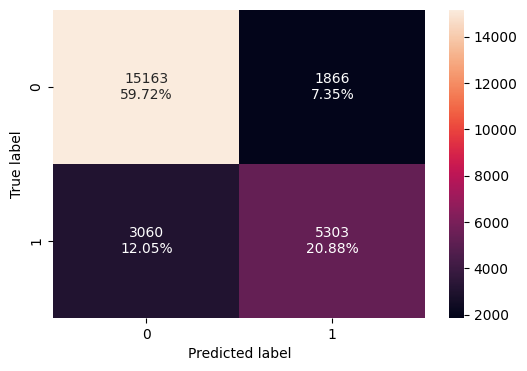

In [ ]:
confusion_matrix_statsmodels(lg, x_train.astype(float), y_train)

In [ ]:
print("Training performance:")
model_performance_classification_statsmodels(lg,x_train, y_train)

Training performance:


Accuracy  Recall  Precision   F1
0      0.81    0.63       0.74 0.68

## Checking for Multicollinearity

- In order to make statistical inferences from a logistic regression model, it is important to ensure that there is no multicollinearity present in the data.

- We will test for multicollinearity using VIF.

**General Rule of thumb:**

* If VIF is 1 then there is no correlation between the $k$th predictor and the remaining predictor variables and  hence  the variance of $\beta_k$ is not inflated at all
*If VIF exceeds 5 or is close to exceeding 5, we say there is moderate multicollinearity.
*If VIF is 10 or exceeding 10, it shows signs of high multicollinearity.

In [ ]:
checking_vif(x_train).sort_values(by = 'VIF',ascending = False)

feature         VIF
0                                  const 39497686.21
27            market_segment_type_Online       71.18
26           market_segment_type_Offline       64.12
25         market_segment_type_Corporate       16.93
24     market_segment_type_Complementary        4.50
2                         no_of_children        2.09
13                    avg_price_per_room        2.07
22        room_type_reserved_Room_Type 6        2.06
10                        repeated_guest        1.78
12  no_of_previous_bookings_not_canceled        1.65
7                           arrival_year        1.43
11          no_of_previous_cancellations        1.40
6                              lead_time        1.40
20        room_type_reserved_Room_Type 4        1.36
1                           no_of_adults        1.35
8                          arrival_month        1.28
15         type_of_meal_plan_Meal Plan 2        1.27
17        type_of_meal_plan_Not Selected        1.27
14                no_of_special_requests        1.25
23        room_type_reserved_Room_Type 7        1.12
18        room_type_reserved_Room_Type 2        1.11
4                      no_of_week_nights        1.10
3                   no_of_weekend_nights        1.07
5             required_car_parking_space        1.04
21        room_type_reserved_Room_Type 5        1.03
16         type_of_meal_plan_Meal Plan 3        1.03
9                           arrival_date        1.01
19        room_type_reserved_Room_Type 3        1.00

*  Excluding the dummy variables, no other predictor variables show a VIF above 5
* We observe that there is no multicollinearity present in the data.
* Hence, The values of coefficient and p-values are reliable.
* Let's remove the insignificant variables (p-value > 0.05) from data.

## Dropping high p-value variables

- We will drop the predictor variables having a p-value greater than 0.05 as they do not significantly impact the target variable.
- But sometimes p-values change after dropping a variable. So, we'll not drop all variables at once.
- Instead, we will do the following:
    - Build a model, check the p-values of the variables, and drop the column with the highest p-value.
    - Create a new model without the dropped feature, check the p-values of the variables, and drop the column with the highest p-value.
    - Repeat the above two steps till there are no columns with p-value > 0.05.

The above process can also be done manually by picking one variable at a time that has a high p-value, dropping it, and building a model again. But that might be a little tedious and using a loop will be more efficient.

In [ ]:
# initial list of columns
cols = x_train.columns.tolist()

# setting an initial max p-value
max_p_value = 1

while len(cols) > 0:
    # defining the train set
    x_train_aux = x_train[cols]

    # fitting the model
    model = sm.Logit(y_train, x_train_aux).fit(disp=False)

    # getting the p-values and the maximum p-value
    p_values = model.pvalues
    max_p_value = max(p_values)

    # name of the variable with maximum p-value
    feature_with_p_max = p_values.idxmax()

    if max_p_value > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break

selected_features = cols
print(selected_features)

['const', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'repeated_guest', 'no_of_previous_cancellations', 'avg_price_per_room', 'no_of_special_requests', 'type_of_meal_plan_Meal Plan 2', 'type_of_meal_plan_Not Selected', 'room_type_reserved_Room_Type 2', 'room_type_reserved_Room_Type 4', 'room_type_reserved_Room_Type 5', 'room_type_reserved_Room_Type 6', 'room_type_reserved_Room_Type 7', 'market_segment_type_Corporate', 'market_segment_type_Offline']


In [ ]:
x_train1 = x_train[selected_features]
x_test1 = x_test[selected_features]

In [ ]:
logit1 = sm.Logit(y_train, x_train1)
lg1 = logit1.fit(disp=False)

print(lg1.summary())

                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                25392
Model:                          Logit   Df Residuals:                    25370
Method:                           MLE   Df Model:                           21
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                  0.3282
Time:                        02:44:17   Log-Likelihood:                -10810.
converged:                       True   LL-Null:                       -16091.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -915.6391    120.471     -7.600      0.000   -1151.758    -679.520
no_of_adults                       0.1088      0.037      2.914      0.

In [ ]:
print("Training performance:")
model_performance_classification_statsmodels(lg1,x_train1, y_train)

Training performance:


Accuracy  Recall  Precision   F1
0      0.81    0.63       0.74 0.68

####  Converting coefficients to odds
* The coefficients of the logistic regression model are in terms of log(odd), to find the odds we have to take the exponential of the coefficients.
* Therefore, **odds =  exp(b)**
* The percentage change in odds is given as **odds = (exp(b) - 1) * 100**

In [ ]:
# converting coefficients to odds
odds = np.exp(lg1.params)

# finding the percentage change
perc_change_odds = (np.exp(lg1.params) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=x_train1.columns).T

const  no_of_adults  no_of_children  no_of_weekend_nights  \
Odds           0.00          1.11            1.17                  1.11   
Change_odd% -100.00         11.49           16.55                 11.47   

             no_of_week_nights  required_car_parking_space  lead_time  \
Odds                      1.04                        0.20       1.02   
Change_odd%               4.26                      -79.70       1.58   

             arrival_year  arrival_month  repeated_guest  \
Odds                 1.57           0.96            0.06   
Change_odd%         57.20          -4.16          -93.52   

             no_of_previous_cancellations  avg_price_per_room  \
Odds                                 1.26                1.02   
Change_odd%                         25.71                1.94   

             no_of_special_requests  type_of_meal_plan_Meal Plan 2  \
Odds                           0.23                           1.18   
Change_odd%                  -77.00                          17.85   

             type_of_meal_plan_Not Selected  room_type_reserved_Room_Type 2  \
Odds                                   1.33                            0.70   
Change_odd%                           33.11                          -29.90   

             room_type_reserved_Room_Type 4  room_type_reserved_Room_Type 5  \
Odds                                   0.75                            0.48   
Change_odd%                          -24.64                          -52.12   

             room_type_reserved_Room_Type 6  room_type_reserved_Room_Type 7  \
Odds                                   0.38                            0.24   
Change_odd%                          -62.02                          -76.17   

             market_segment_type_Corporate  market_segment_type_Offline  
Odds                                  0.45                         0.17  
Change_odd%                         -54.67                       -83.23

**Coefficient interpretations**
* `repeated_guest`: Holding all other features constant a 1 unit change in repeated_guest will decrease the odds of a booking getting cancelled by ~.06 times or a ~93.53% decrease in odds of booking getting cancelled.

* `market_segment_type_Offline`: Holding all other features constant a 1 unit change in 'market_segment_type_Offline' will decrease the odds of a booking getting cancelled by ~.17 times or a ~83.25% decrease in odds of booking getting cancelled.

* `no_of_special_requests`: Holding all other features constant a 1 unit change in 'no_of_special_requests' will decrease the odds of a booking getting cancelled by ~.23 times or a ~77% decrease in odds of booking getting cancelled.

* `no_of_adults`: Holding all other features constant a 1 unit change in no_of_adults will increase the odds of a booking getting cancelled by ~1.11 times or a ~11.48% increase in odds of booking getting cancelled.

* `no_of_children`: Holding all other features constant a 1 unit change in no_of_children will increase the odds of a booking getting cancelled by ~1.17 times or a ~16.58% increase in odds of booking getting cancelled.

* `no_of_weekend_nights`: Holding all other features constant a 1 unit change in no_of_weekend_nights will increase the odds of a booking getting cancelled by ~1.11 times or a ~11.48% increase in odds of booking getting cancelled.

* `no_of_week_nights`: Holding all other features constant a 1 unit change in no_of_week_nights will increase the odds of a booking getting cancelled by ~1.04 times or a ~4.26% increase in odds of booking getting cancelled.

* `required_car_parking_space`: Holding all other features constant a 1 unit change in required_car_parking_space will decrease the odds of a booking getting cancelled by ~.20 times or a ~79.70% decrease in odds of booking getting cancelled.

* `lead_time`: Holding all other features constant a 1 unit change in lead_time will increase the odds of a booking getting cancelled by ~1.02 times or a ~1.58% increase in odds of booking getting cancelled.

* `no_of_previous_cancellations`:Holding all other features constant, a unit change in no_of_previous_cancellations will increase the odds of a person cancelling the booking by 1.25 times or a 25.70% increase in the odds of cancelling the booking.

* `repeated_guest`: Holding all other features constant, being a repeated guest will decrease the odds of a person canceling the booking by 0.06 times or a 93.52% decrease in the odds of canceling the booking.

* `avg_price_per_room`: Holding all other features constant, a unit change in avg_price_per_room will increase the odds of a person canceling the booking by 1.02 times or a 1.94% increase in the odds of canceling the booking.

* `market_segment_type_Offline`: Holding all other features constant, being in the Offline market segment will decrease the odds of a person canceling the booking by 0.452 times or a 54.74% decrease in the odds of canceling the booking.


## Checking model performance on the training set

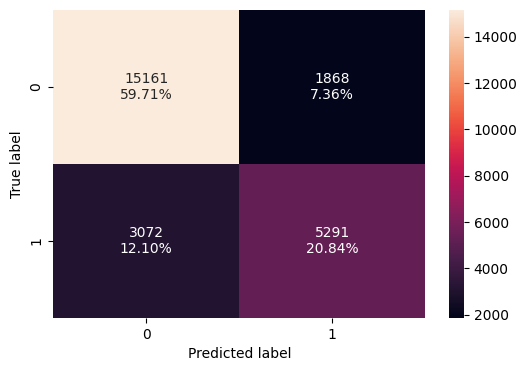

In [ ]:
# creating confusion matrix
confusion_matrix_statsmodels(lg1,x_train1.astype(float), y_train)

In [ ]:
print("Training performance:")
log_reg_model_train_perf = model_performance_classification_statsmodels(lg1,x_train1, y_train)


print("Training performance:")
log_reg_model_train_perf

Training performance:
Training performance:


Accuracy  Recall  Precision   F1
0      0.81    0.63       0.74 0.68

## Model Performance Improvement

* Let's see if the f1_score can be improved further by changing the model threshold
* First, we will check the ROC curve, compute the area under the ROC curve (ROC-AUC), and then use it to find the optimal threshold
* Next, we will check the Precision-Recall curve to find the right balance between precision and recall as our metric of choice is f1_score

### ROC Curve and ROC-AUC

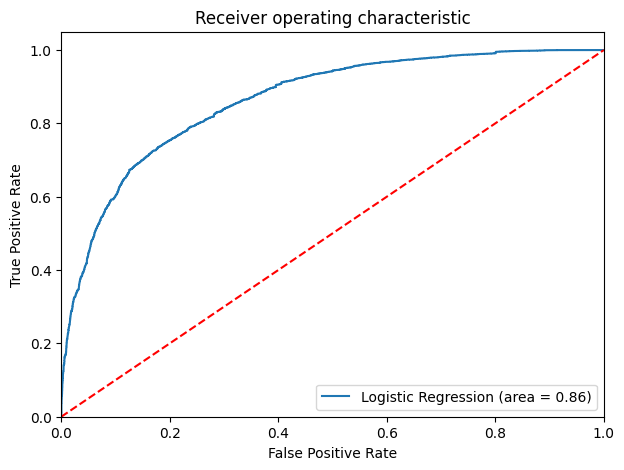

In [ ]:
logit_roc_auc_train = roc_auc_score(y_train, lg1.predict(x_train1))
fpr, tpr, thresholds = roc_curve(y_train, lg1.predict(x_train1))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

*  Logistic Regression model is giving a good performance on training set

### Optimal threshold using AUC-ROC curve

In [ ]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_train, lg1.predict(x_train1))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.3700522558708252


**Checking model performance on training set**

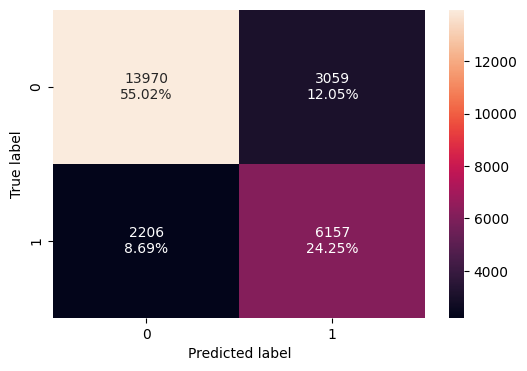

In [ ]:
#Create the confusion_matrix for x_train1 and y_train with optimal_threshold_auc_roc as threshold
confusion_matrix_statsmodels(lg1,x_train1,y_train,optimal_threshold_auc_roc)

In [ ]:
# checking model performance for this model
log_reg_model_train_perf_auc_roc = model_performance_classification_statsmodels(lg1,x_train1,y_train,optimal_threshold_auc_roc)

print("Training performance:")
log_reg_model_train_perf_auc_roc

Training performance:


Accuracy  Recall  Precision   F1
0      0.79    0.74       0.67 0.70

* F1 score and Recall of model has increased but the other metrics have reduced.

### Precision-Recall Curve

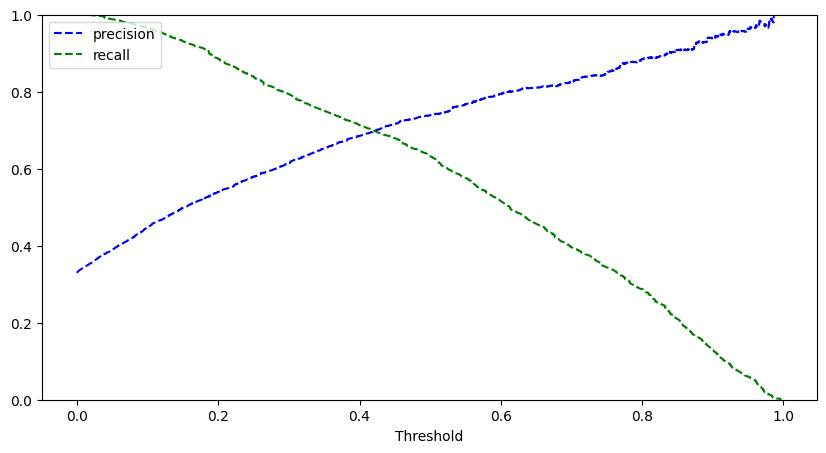

In [ ]:
y_scores = lg1.predict(x_train1)
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])



plt.figure(figsize=(10 ,5))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

* At the threshold of 0.42, we get balanced recall and precision.

In [ ]:
# setting the threshold
optimal_threshold_prec_recall_curve = 0.42

**Checking model performance on training set**

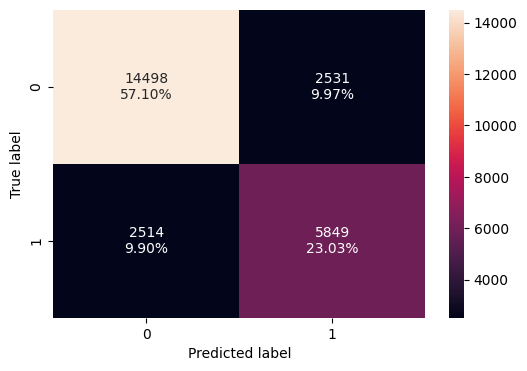

In [ ]:
#Create the confusion_matrix
confusion_matrix_statsmodels(lg1,x_train1,y_train,optimal_threshold_prec_recall_curve)

In [ ]:
# checking model performance for this model
log_reg_model_train_perf_precision_recall = model_performance_classification_statsmodels(lg1,x_train1,y_train,optimal_threshold_prec_recall_curve)

print("Training performance:")
log_reg_model_train_perf_precision_recall

Training performance:


Accuracy  Recall  Precision   F1
0      0.80    0.70       0.70 0.70

* Precision has improved compared to the other models
*F1 score and Recall are lowest in this model compared to other models

##Let's check the performance on the test set


- We have to first drop the columns from the test set that were dropped from the training set.

In [ ]:
x_test1 = x_test[x_train1.columns]
x_test1 = x_test1.astype(float)

###**Using model with default threshold**

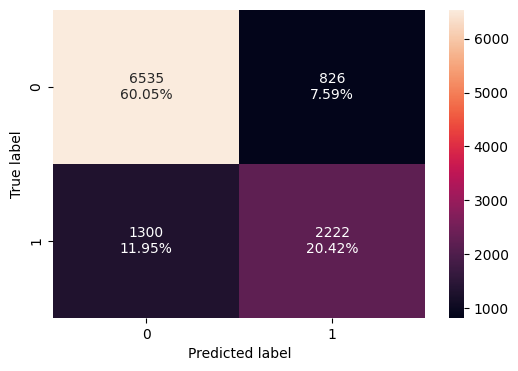

In [ ]:
# creating confusion matrix
confusion_matrix_statsmodels(lg1, x_test1, y_test)

In [ ]:
log_reg_model_test_perf = model_performance_classification_statsmodels(
    lg1, x_test1, y_test
)

print("Test performance:")
log_reg_model_test_perf

Test performance:


Accuracy  Recall  Precision   F1
0      0.80    0.63       0.73 0.68

- The model is giving a good f1_score of ~0.68 and ~0.68 on the train and test sets respectively
- As the train and test performances are comparable, the model is not overfitting

### **ROC curve on test set**

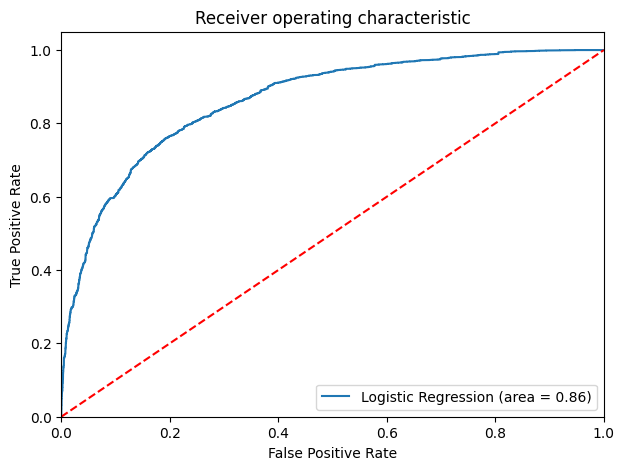

In [ ]:
logit_roc_auc_test = roc_auc_score(y_test, lg1.predict(x_test1))
fpr, tpr, thresholds = roc_curve(y_test, lg1.predict(x_test1))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

**Using model with threshold=0.37**

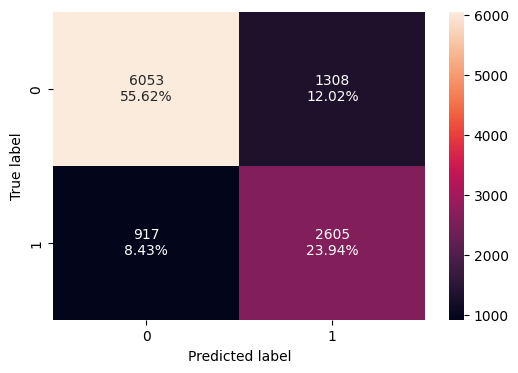

In [ ]:
# creating confusion matrix
confusion_matrix_statsmodels(lg1, x_test1, y_test, threshold=optimal_threshold_auc_roc)

In [ ]:
# checking model performance for this model
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_statsmodels(
    lg1, x_test1, y_test, threshold=optimal_threshold_auc_roc
)
print("Test performance:")
log_reg_model_test_perf_threshold_auc_roc

Test performance:


Accuracy  Recall  Precision   F1
0      0.80    0.74       0.67 0.70

**Using model with threshold = 0.42**

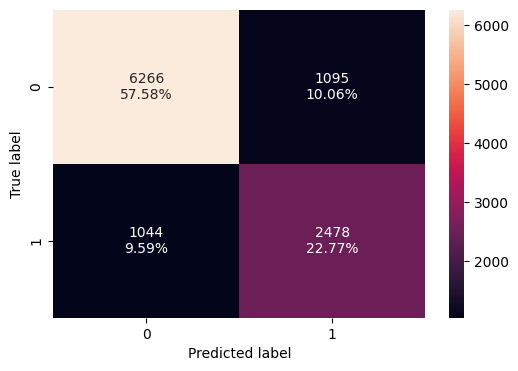

In [ ]:
# creating confusion matrix
confusion_matrix_statsmodels(lg1, x_test1, y_test, threshold=optimal_threshold_prec_recall_curve)

In [ ]:
log_reg_model_test_perf_precision_recall = model_performance_classification_statsmodels(
    lg1, x_test1, y_test, threshold=optimal_threshold_prec_recall_curve
)
print("Test performance:")
log_reg_model_test_perf_precision_recall

Test performance:


Accuracy  Recall  Precision   F1
0      0.80    0.70       0.69 0.70

## Final Model Performance Summary

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_auc_roc.T,
        log_reg_model_train_perf_precision_recall.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression  default Threshold (0.5)",
    "Logistic Regression-0.37 Threshold",
    "Logistic Regression-0.42 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


Logistic Regression  default Threshold (0.5)  \
Accuracy                                           0.81   
Recall                                             0.63   
Precision                                          0.74   
F1                                                 0.68   

           Logistic Regression-0.37 Threshold  \
Accuracy                                 0.79   
Recall                                   0.74   
Precision                                0.67   
F1                                       0.70   

           Logistic Regression-0.42 Threshold  
Accuracy                                 0.80  
Recall                                   0.70  
Precision                                0.70  
F1                                       0.70

In [ ]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_precision_recall.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression default Threshold (0.5)",
    "Logistic Regression-0.37 Threshold",
    "Logistic Regression-0.42 Threshold",
]

print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


Logistic Regression default Threshold (0.5)  \
Accuracy                                          0.80   
Recall                                            0.63   
Precision                                         0.73   
F1                                                0.68   

           Logistic Regression-0.37 Threshold  \
Accuracy                                 0.80   
Recall                                   0.74   
Precision                                0.67   
F1                                       0.70   

           Logistic Regression-0.42 Threshold  
Accuracy                                 0.80  
Recall                                   0.70  
Precision                                0.69  
F1                                       0.70

*  All the three models are performing well on both training and test data without the problem of overfitting
*  The  logistic regression models with a  threshold (0.37)  and threshold(.42) have the same F1 - Score on both training and test sets.
*However, we will choose the logistic regression model with a threshold (0.37) as the final model since it is giving a slightly high recall score on the train and test sets than the other Logistic Regression model with threshold(.42)


**Conclusions**
*  We were able to build a predictive model that can be used by INN Hotels to predict which bookings will be canceled with an F1 score of 0.70 on the training set.

*  The model has a Recall score of (74%),that means,out of all actual cancellations, the model correctly identifies 74% of cancellations

* All the logistic regression models are performing well on both training and test data without the problem of overfitting

* Coefficients for the number of adults,no_of_children, the lead time prior to a booking, the arrival year (i.e., 2018 v. 2017), the number of previous cancellations, the average room price, the total nights booked, selecting Meal Plan 2, and not selecting a meal plan are all positive, meaning an increase in these will lead to increase in chances of a hotel booking being cancelled.

* Coefficients for requiring a parking space, arrival month, being a repeat guest, the number of special requests,the market segments for Corporate and Offline and reserving Room_Type 2,Room_Type 4,Room_Type 5,Room_Type 6,Room_Type 7 are all negative, meaning an increase in these will lead to decrease in chances of a hotel booking being cancelled.

## Building a Decision Tree model

### Data Preparation for modeling (Decision Tree)

- We want to predict which bookings will be canceled.
- Before we proceed to build a model, we'll have to encode categorical features.
- We'll split the data into train and test to be able to evaluate the model that we build on the train data.

In [ ]:
X = data.drop(['booking_status'],axis = 1)
Y = data['booking_status']

#To create dummies for categorical variables
X = pd.get_dummies(X,drop_first = True)
X = X.astype(float)

# Splitting data in train and test sets in the ratio 70:30
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = .3,random_state = 1,stratify = Y )


In [ ]:
print("Shape of Training set :",X_train.shape)
print("Shape of test set :",X_test.shape)
print("Percentage of classes in training set")
print(Y_train.value_counts(normalize = True))
print("Percentage of classes in test set")
print(Y_test.value_counts(normalize = True))

Shape of Training set : (25392, 27)
Shape of test set : (10883, 27)
Percentage of classes in training set
booking_status
0   0.67
1   0.33
Name: proportion, dtype: float64
Percentage of classes in test set
booking_status
0   0.67
1   0.33
Name: proportion, dtype: float64


## Model evaluation criterion

### Model can make wrong predictions as:

1. Predicting a customer will not cancel their booking but in reality, the customer will cancel their booking.
2. Predicting a customer will cancel their booking but in reality, the customer will not cancel their booking.

### Which case is more important?
* Both the cases are important as:

* If we predict that a booking will not be canceled and the booking gets canceled then the hotel will lose resources and will have to bear additional costs of distribution channels.

* If we predict that a booking will get canceled and the booking doesn't get canceled the hotel might not be able to provide satisfactory services to the customer by assuming that this booking will be canceled. This might damage the brand equity.



### How to reduce the losses?

* Hotel would want `F1 Score` to be maximized, greater the F1  score higher are the chances of minimizing False Negatives and False Positives.

### Decision Tree (default)

In [ ]:
#Fit the model
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=1)

#### Checking model performance on training set

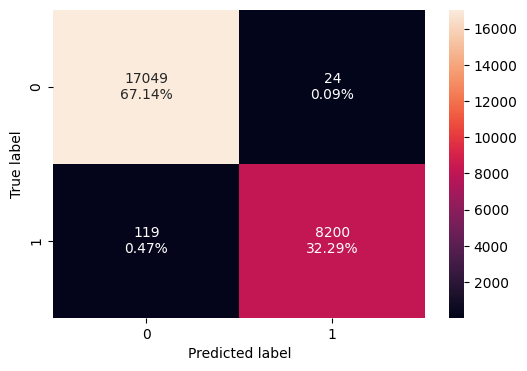

In [ ]:
#create confusion matrix for train data
confusion_matrix_statsmodels(model, X_train, Y_train)

In [ ]:
# To check performance on training data
decision_tree_perf_train = model_performance_classification_statsmodels(model, X_train, Y_train)
decision_tree_perf_train

Accuracy  Recall  Precision   F1
0      0.99    0.99       1.00 0.99

#### Checking model performance on test set

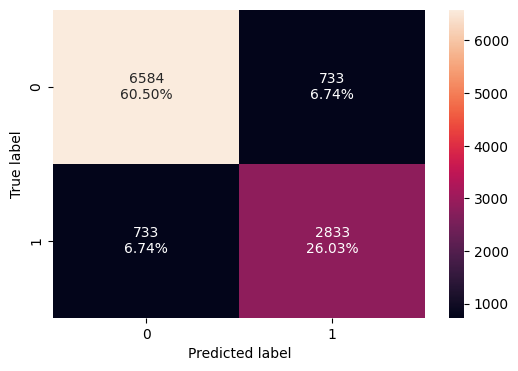

In [ ]:
#create confusion matrix for test data
confusion_matrix_statsmodels(model, X_test, Y_test)

In [ ]:
# To check performance on test data
decision_tree_perf_test = model_performance_classification_statsmodels(model, X_test, Y_test)
decision_tree_perf_test

Accuracy  Recall  Precision   F1
0      0.87    0.79       0.79 0.79

Without any pruning decision trees can overfit the training data. While testing on the test dataset resulted in a .79 F1 score, more evaluation should be done on this model to avoid overfitting.

**Before pruning the tree let's check the important features.**

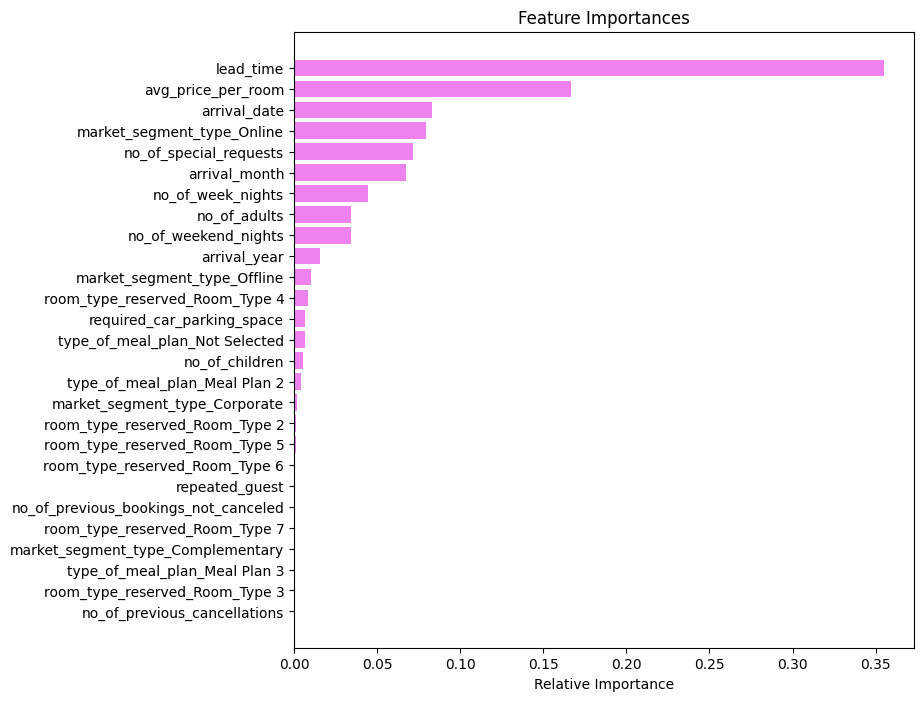

In [ ]:
feature_names = list(X_train.columns)
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


According to this decison tree the most relevant independent variables include:

* Lead time
* Average price per room
* Arrival date
* If booking was made online.
*Number of special requests

## Do we need to prune the tree?

*  There is a huge disparity in performance of model on training set and test set,which suggests the model is overfitting

**Let's use pruning techniques to try and reduce overfitting.**

## Decision Tree (Pre-pruning)

**Using GridSearch for Hyperparameter tuning of our tree model**

* Hyperparameter tuning is also tricky in the sense that there is no direct way to calculate how a change in the
  hyperparameter value will reduce the loss of your model, so we usually resort to experimentation. i.e we'll use Grid search
* Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.
* It is an exhaustive search that is performed on a the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [ ]:
base_dt_model = DecisionTreeClassifier(random_state = 1)

#Grid parameters to choose from
hyper_params = {
    "class_weight": [None, "balanced"],
    "max_depth": np.arange(2, 7, 2),
    "max_leaf_nodes": [50, 75, 150, 250],
    "min_samples_split": [10, 30, 50, 70],
}

f1_scorer = make_scorer(f1_score)

#Grid search
grid_obj = GridSearchCV(estimator=base_dt_model,param_grid=hyper_params,scoring=f1_scorer,cv=5)
grid_obj.fit(X_train,Y_train)

# Set the clf to the best combination of parameters
best_dt_model = grid_obj.best_estimator_

# Fit the best algorithm to the data.
best_dt_model.fit(X_train,Y_train)


DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=50,
                       min_samples_split=70, random_state=1)

#### Checking model performance on training set

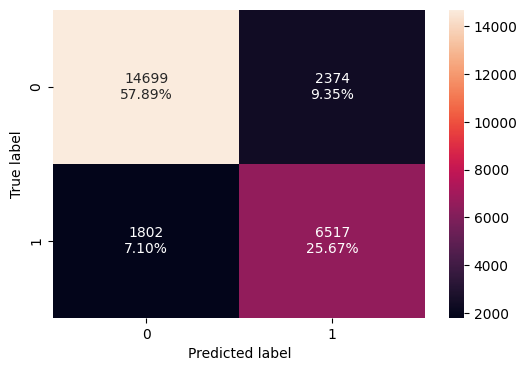

In [ ]:
#create confusion matrix
confusion_matrix_statsmodels(best_dt_model, X_train, Y_train)

In [ ]:
decision_tree_tune_perf_train = model_performance_classification_statsmodels(best_dt_model, X_train, Y_train)
decision_tree_tune_perf_train

Accuracy  Recall  Precision   F1
0      0.84    0.78       0.73 0.76

#### Checking model performance on test set

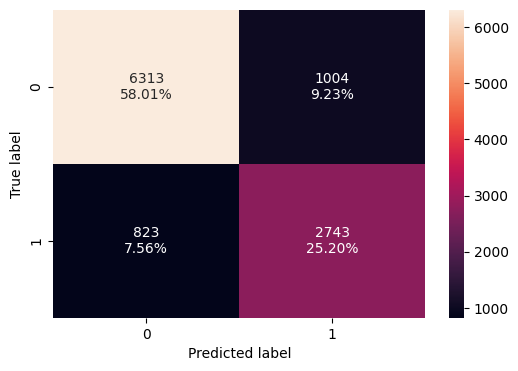

In [ ]:
#create confusion matrix
confusion_matrix_statsmodels(best_dt_model, X_test, Y_test)

In [ ]:
decision_tree_tune_perf_test = model_performance_classification_statsmodels(best_dt_model, X_test, Y_test)
decision_tree_tune_perf_test

Accuracy  Recall  Precision   F1
0      0.83    0.77       0.73 0.75

* The model is giving a generalized result now since the f1 scores on both the train and test data are coming to be around 0.75 which shows that the model is able to generalize well on unseen data.

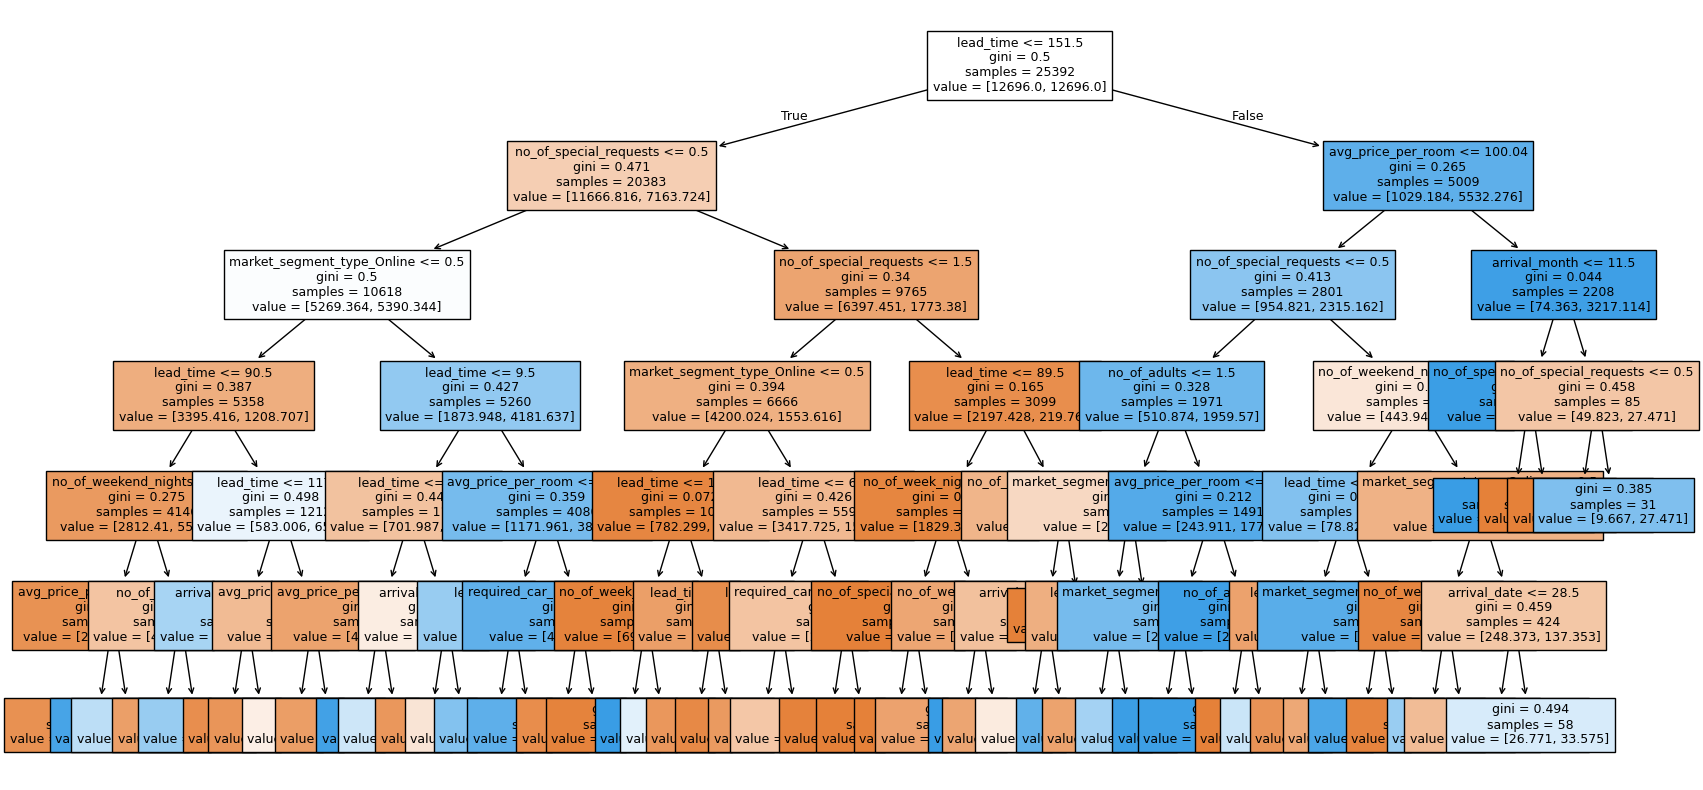

In [ ]:
plt.figure(figsize=(20, 10))
out = tree.plot_tree(
    best_dt_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [ ]:
# Text report showing the rules of a decision tree -
print(tree.export_text(best_dt_model, feature_names=feature_names, show_weights=True))

|--- lead_time <= 151.50
|   |--- no_of_special_requests <= 0.50
|   |   |--- market_segment_type_Online <= 0.50
|   |   |   |--- lead_time <= 90.50
|   |   |   |   |--- no_of_weekend_nights <= 1.50
|   |   |   |   |   |--- avg_price_per_room <= 202.00
|   |   |   |   |   |   |--- weights: [2356.56, 293.02] class: 0
|   |   |   |   |   |--- avg_price_per_room >  202.00
|   |   |   |   |   |   |--- weights: [1.49, 21.37] class: 1
|   |   |   |   |--- no_of_weekend_nights >  1.50
|   |   |   |   |   |--- no_of_adults <= 1.50
|   |   |   |   |   |   |--- weights: [104.11, 157.19] class: 1
|   |   |   |   |   |--- no_of_adults >  1.50
|   |   |   |   |   |   |--- weights: [350.25, 83.94] class: 0
|   |   |   |--- lead_time >  90.50
|   |   |   |   |--- lead_time <= 117.50
|   |   |   |   |   |--- arrival_month <= 10.50
|   |   |   |   |   |   |--- weights: [245.40, 512.78] class: 1
|   |   |   |   |   |--- arrival_month >  10.50
|   |   |   |   |   |   |--- weights: [43.13, 4.58] class: 0


**Observations from the pre-pruned tree:**

Using the above extracted decision rules we can make interpretations from the decision tree model like:


* If the lead_time is less than or equal to 151.50, the no_of_special_requests is less than or equal to 0.50 , the market_segment_type_Online is less than or equal to 0.50 ,lead_time is less than or equal to 90.50,the no_of_weekend_nights is less than or equal to 1.50 and the avg_price_per_room is less than or equal to 202 $, then the then the booking won't be getting cancelled

`Interpretations from other decision rules can be made similarly`

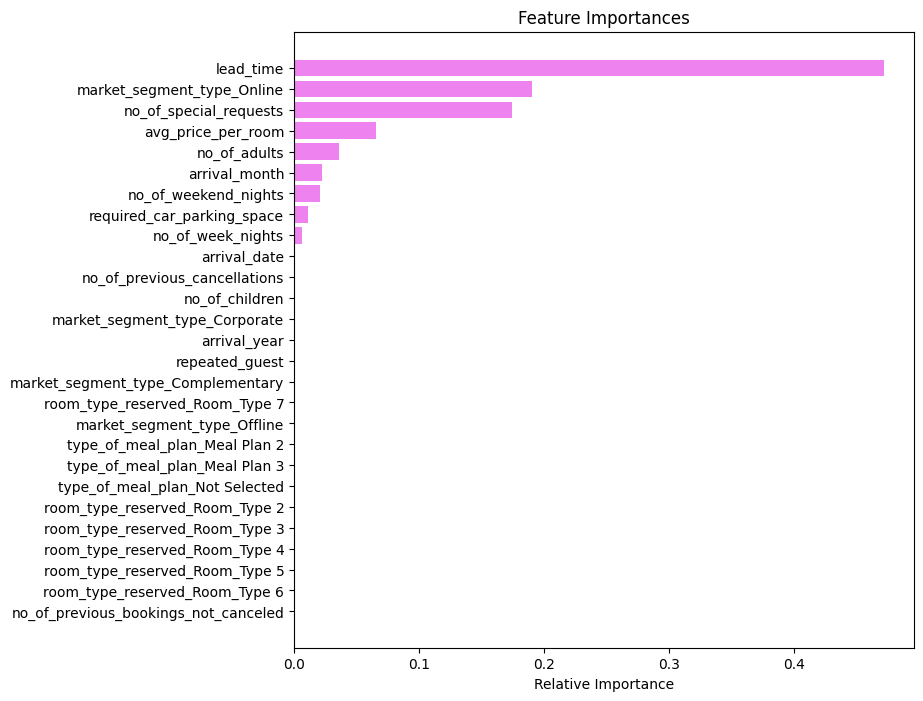

In [ ]:
# importance of features in the tree building

importances = best_dt_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

After the first tree pruning our independent variables order of importance has changed:

* Lead time
*If booking was made online
*Number of special requests
*Average price per room
*Number of adults

Similar to our initial observation on importance, lead time, market segment type-online, and average price are still important variables.
* New variables of note are number of special requests, number of adults.

## Decision Tree (Post pruning)

---



*  Cost complexity pruning provides another option to control the size of a tree.
*In`DecisionTreeClassifier`, this pruning technique is parameterized by the
cost complexity parameter, ``ccp_alpha``.
*Greater values of ``ccp_alpha``increase the number of nodes pruned.

###Cost Complexity Pruning

In [ ]:
dt_model_ccp = DecisionTreeClassifier(random_state= 1,class_weight = 'balanced')
path = dt_model_ccp.cost_complexity_pruning_path(X_train,Y_train)
ccp_alphas,impurities = abs(path.ccp_alphas),path.impurities


In [ ]:
pd.DataFrame(path)

ccp_alphas  impurities
0           0.00        0.01
1          -0.00        0.01
2           0.00        0.01
3           0.00        0.01
4           0.00        0.01
...          ...         ...
1648        0.01        0.33
1649        0.01        0.34
1650        0.01        0.35
1651        0.03        0.42
1652        0.08        0.50

[1653 rows x 2 columns]

**Total impurity of leaves vs effective alphas of pruned tree**

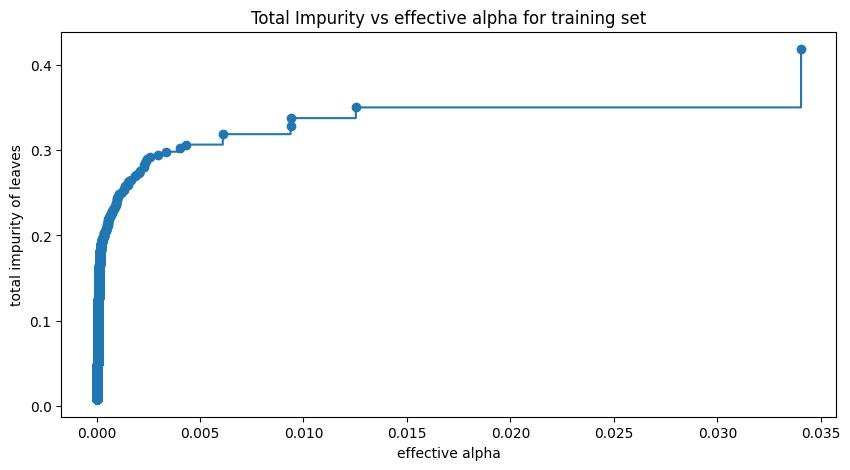

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

Next, we train a decision tree using the effective alphas. The last value
in ``ccp_alphas`` is the alpha value that prunes the whole tree,
leaving the tree, ``clfs[-1]``, with one node.

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=1, ccp_alpha=ccp_alpha, class_weight="balanced"
    )
    clf.fit(X_train, Y_train)
    clfs.append(clf)
print( "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.08205938055988293


For the remainder, we remove the last element in
``clfs`` and ``ccp_alphas``, because it is the trivial tree with only one
node. Here we show that the number of nodes and tree depth decreases as alpha
increases.

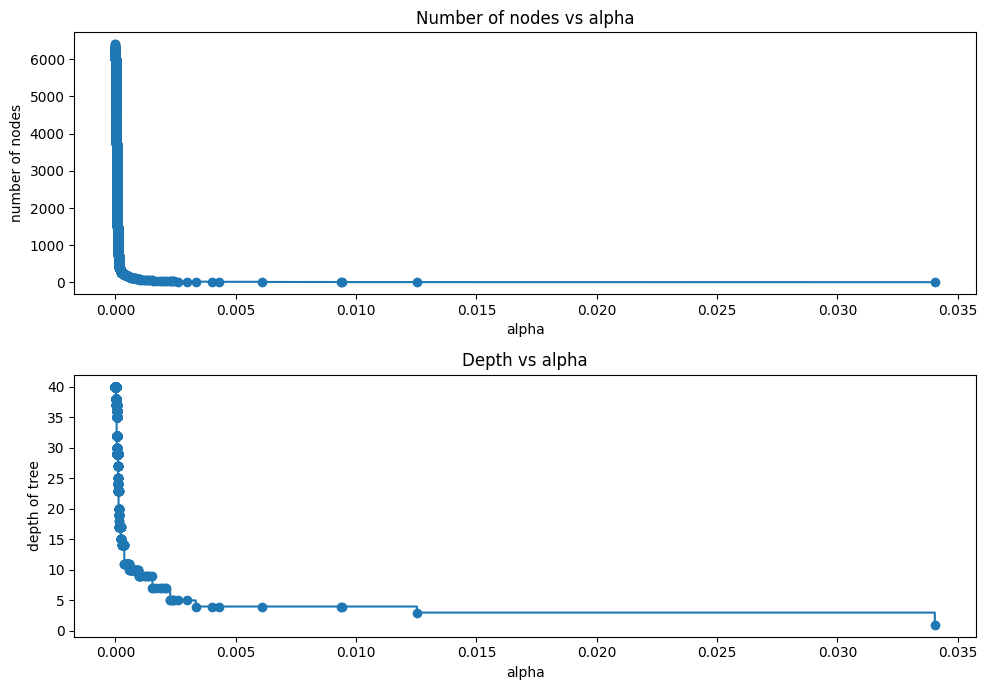

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

###**F1 Score vs alpha for training and testing sets**

In [ ]:
f1_score_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    values_train = f1_score(Y_train, pred_train)
    f1_score_train.append(values_train)

In [ ]:
f1_score_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    values_test = f1_score(Y_test, pred_test)
    f1_score_test.append(values_test)

In [ ]:
train_scores = [clf.score(X_train, Y_train) for clf in clfs]
test_scores = [clf.score(X_test, Y_test) for clf in clfs]

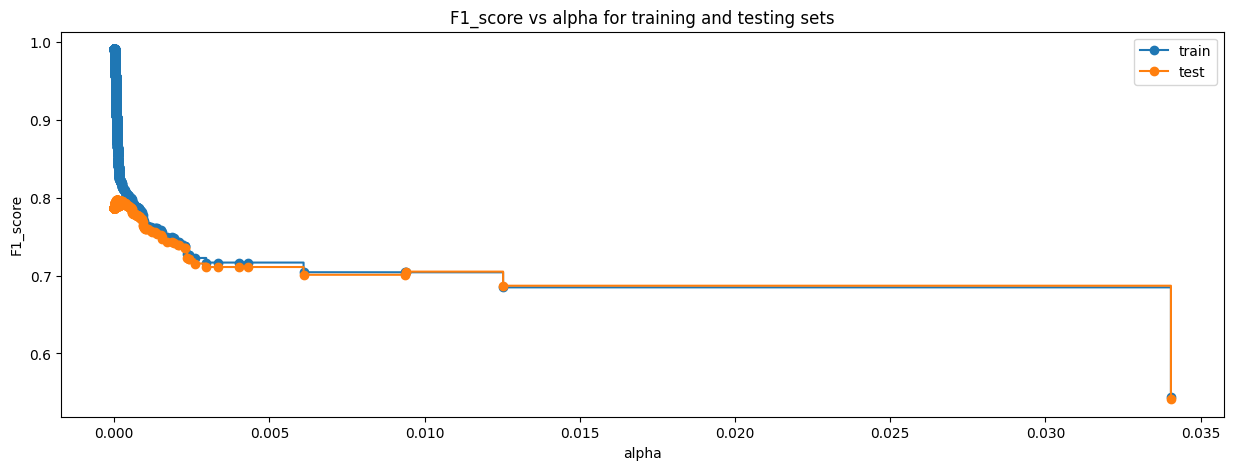

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("F1_score")
ax.set_title("F1_score vs alpha for training and testing sets")
ax.plot(
    ccp_alphas, f1_score_train, marker="o", label="train", drawstyle="steps-post",
)
ax.plot(ccp_alphas, f1_score_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
# creating the model where we get highest train and test f1_score
index_best_model = np.argmax(f1_score_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.00010709530427669946,
                       class_weight='balanced', random_state=1)


### Checking performance on training set

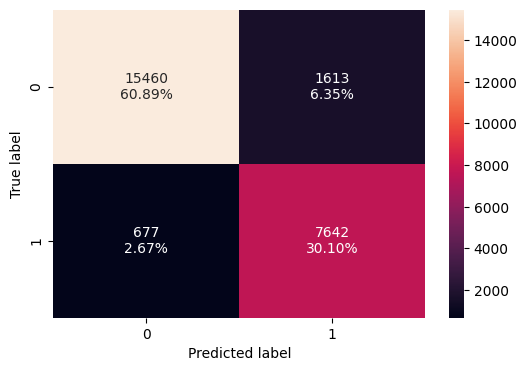

In [ ]:
confusion_matrix_statsmodels(best_model, X_train, Y_train)

In [ ]:
decision_tree_post_perf_train = model_performance_classification_statsmodels(
    best_model, X_train, Y_train
)
decision_tree_post_perf_train

Accuracy  Recall  Precision   F1
0      0.91    0.92       0.83 0.87

### Checking performance on test set

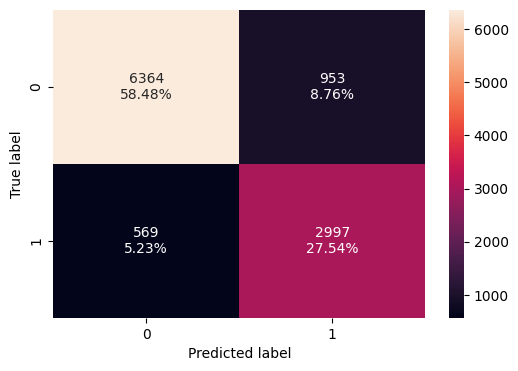

In [ ]:
confusion_matrix_statsmodels(best_model, X_test, Y_test)

In [ ]:
decision_tree_post_perf_test = model_performance_classification_statsmodels(best_model, X_test, Y_test)
decision_tree_post_perf_test

Accuracy  Recall  Precision   F1
0      0.86    0.84       0.76 0.80

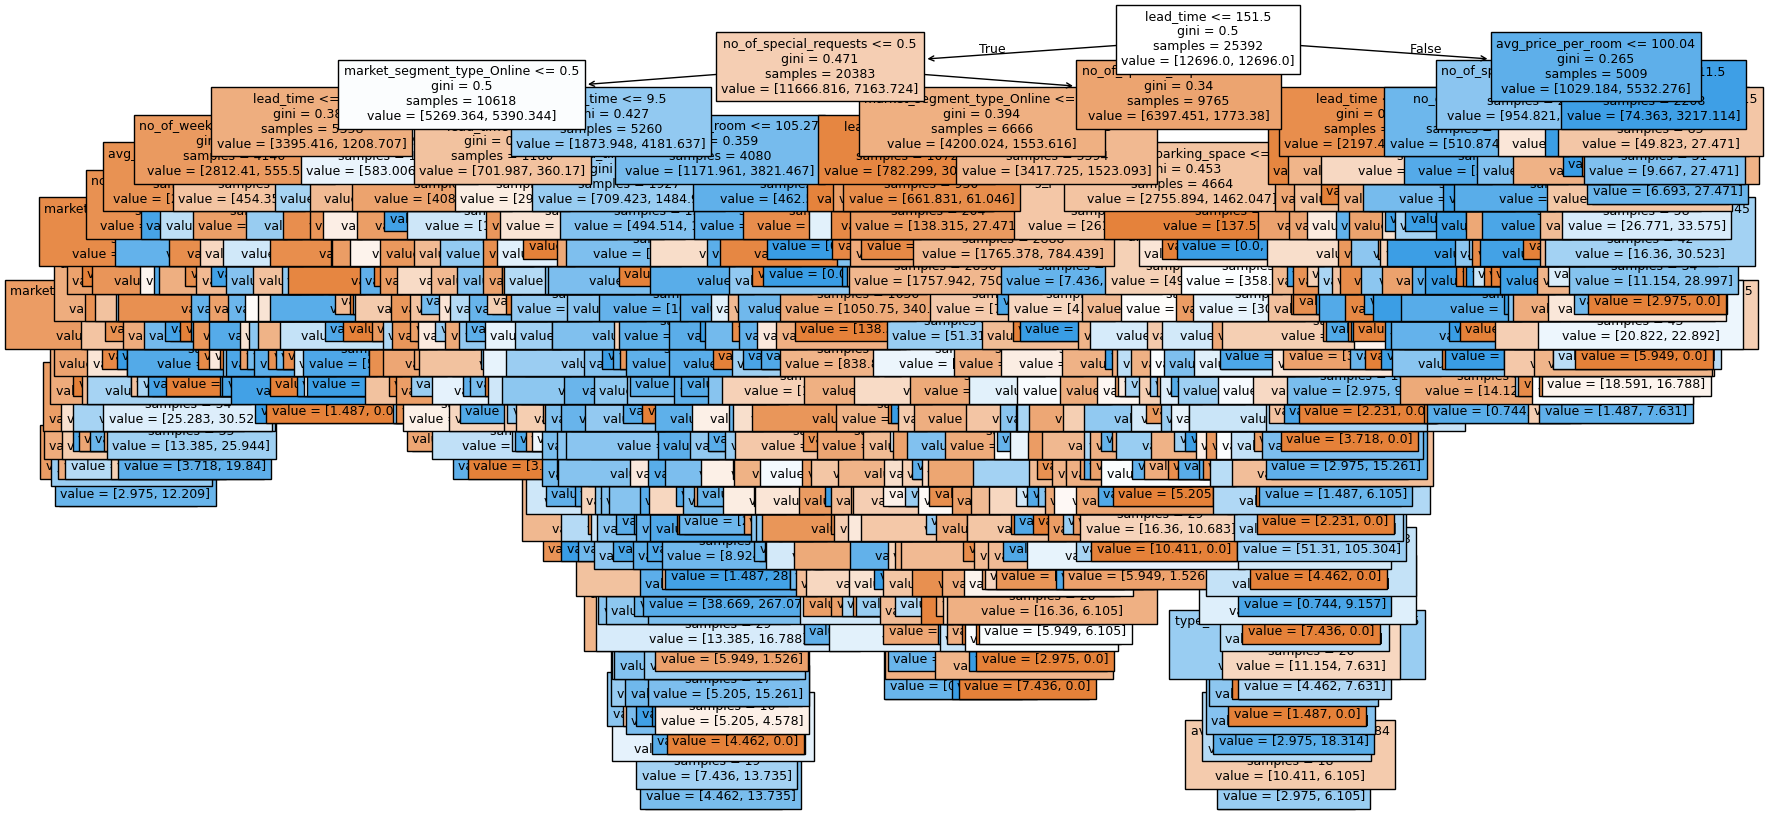

In [ ]:
plt.figure(figsize=(20, 10))
out = tree.plot_tree(
    best_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [ ]:
# Text report showing the rules of a decision tree -

print(tree.export_text(best_model, feature_names=feature_names, show_weights=True))

|--- lead_time <= 151.50
|   |--- no_of_special_requests <= 0.50
|   |   |--- market_segment_type_Online <= 0.50
|   |   |   |--- lead_time <= 90.50
|   |   |   |   |--- no_of_weekend_nights <= 1.50
|   |   |   |   |   |--- avg_price_per_room <= 202.00
|   |   |   |   |   |   |--- no_of_weekend_nights <= 0.50
|   |   |   |   |   |   |   |--- market_segment_type_Offline <= 0.50
|   |   |   |   |   |   |   |   |--- repeated_guest <= 0.50
|   |   |   |   |   |   |   |   |   |--- avg_price_per_room <= 87.25
|   |   |   |   |   |   |   |   |   |   |--- market_segment_type_Corporate <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- weights: [54.29, 0.00] class: 0
|   |   |   |   |   |   |   |   |   |   |--- market_segment_type_Corporate >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |--- avg_price_per_room >  87.25
|   |   |   |   |   |   |   |   |   |   |--- lead_time <= 1.50
|   |   |   |   |   |   |   |   |  

**Observations from the post-pruned tree:**

Using the above extracted decision rules we can make interpretations from the decision tree model like:
* If the lead_time is less than or equal to 151.50, the no_of_special_requests is less than or equal to 0.50 , the market_segment_type_Online is less than or equal to 0.50 ,lead_time is less than or equal to 90.50,the no_of_weekend_nights is less than or equal to 1.50 and the avg_price_per_room is less than or equal to 202,no_of_weekend_nigts is less than or equal to .50 ,the market_segment_type_Offline is less than or equal to 0.50,repeated_guest less than or equal to .50,avg_price_per_room less than or equal to 87.25 and market_segment_type_Corporate less than or equal to .50, then the booking won't be getting cancelled

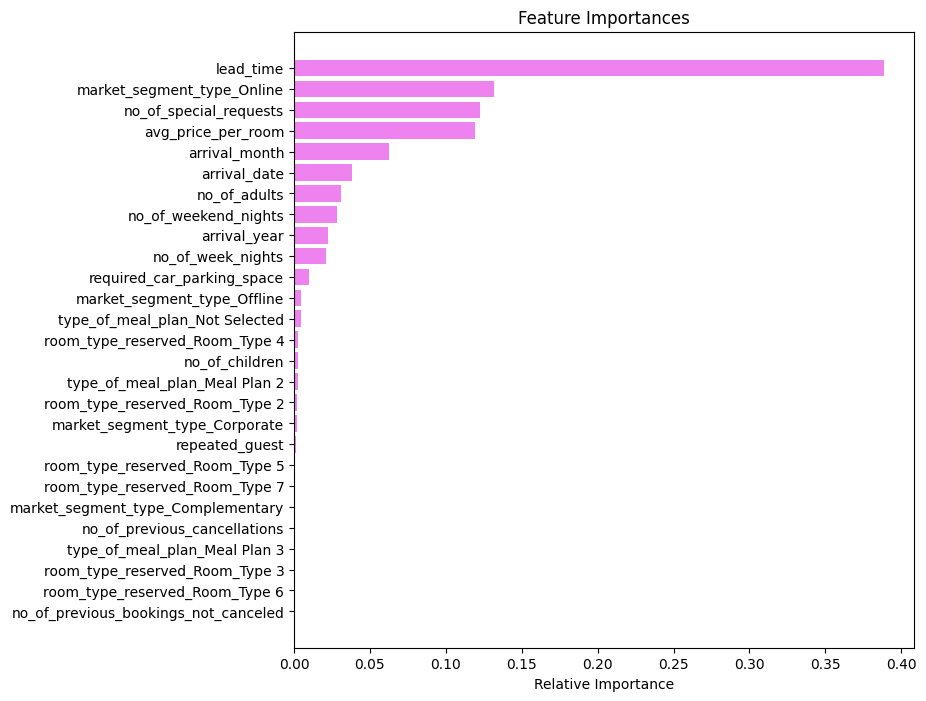

In [ ]:
importances = best_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

* In the post tuned decision tree also, lead_time ,market_segment_type_Online ,no_of_special_requests and avg_price_per_room are the most important features.

## Model Performance Comparison and Conclusions

Training performance comparison:

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        decision_tree_perf_train.T,
        decision_tree_tune_perf_train.T,
        decision_tree_post_perf_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree without Pruning",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


Decision Tree without Pruning  Decision Tree (Pre-Pruning)  \
Accuracy                            0.99                         0.84   
Recall                              0.99                         0.78   
Precision                           1.00                         0.73   
F1                                  0.99                         0.76   

           Decision Tree (Post-Pruning)  
Accuracy                           0.91  
Recall                             0.92  
Precision                          0.83  
F1                                 0.87

Testing performance comparison:

In [ ]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        decision_tree_perf_test.T,
        decision_tree_tune_perf_test.T,
        decision_tree_post_perf_test.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree without pruning",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


Decision Tree without pruning  Decision Tree (Pre-Pruning)  \
Accuracy                            0.87                         0.83   
Recall                              0.79                         0.77   
Precision                           0.79                         0.73   
F1                                  0.79                         0.75   

           Decision Tree (Post-Pruning)  
Accuracy                           0.86  
Recall                             0.84  
Precision                          0.76  
F1                                 0.80

Observations:
*  Decision Tree models with pre-pruning and post-pruning showed good performance and no signs of overfitting in the final models
*We will choose post pruned tree as the best model since it is having highest F! score of .92 and Recall of .92



**Conclusions and Recommendations**

* We were able to build a predictive model that can be used by INN Hotels to predict which bookings will be canceled with an F1 score of 0.87 and Recall score of .92 and Precision .76 on the training set.

* The model built can be used to predict if the booking is going to be cancelled or not and can correctly identify 92%(based on recall score) of those cancellations

* The model has a precision score of .76,which means out of all bookings the model predicts as "canceled," 76% are actually canceled

* lead_time, market_segment_type_Online,average price per room and number of special requests are the most important variables in predicting whether the booking will be cancelled or not
* Lead Time: Bookings with a lead time greater than 151.50 are more likely to be canceled.
* Bookings with a higher average price per room (> 202$) are more likely to be canceled.

*    The company should give a vigilant eye for these values in order to detect booking cancellations

##Compare Decision Tree and Logistic Regression model

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        decision_tree_tune_perf_train.T,
        decision_tree_post_perf_train.T,
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_auc_roc.T,
        log_reg_model_train_perf_precision_recall.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)" ,
    "Logistic Regression default Threshold (0.5)",
    "Logistic Regression-0.37 Threshold",
    "Logistic Regression-0.42 Threshold",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


Decision Tree (Pre-Pruning)  Decision Tree (Post-Pruning)  \
Accuracy                          0.84                          0.91   
Recall                            0.78                          0.92   
Precision                         0.73                          0.83   
F1                                0.76                          0.87   

           Logistic Regression default Threshold (0.5)  \
Accuracy                                          0.81   
Recall                                            0.63   
Precision                                         0.74   
F1                                                0.68   

           Logistic Regression-0.37 Threshold  \
Accuracy                                 0.79   
Recall                                   0.74   
Precision                                0.67   
F1                                       0.70   

           Logistic Regression-0.42 Threshold  
Accuracy                                 0.80  
Recall                                   0.70  
Precision                                0.70  
F1                                       0.70

Observations:
*  As can be seen,among the different models tested,Decision Tree model with Post pruning has the highest F1-score(.87) , the highest Recall(.92) and highest Precision(.83)
*The recommended model is the decision tree with post-pruning for maximizing the detection of booking cancellations.

## **Actionable Insights and Recommendations**

- **What profitable policies for cancellations and refunds can the hotel adopt?**

  * The hotels can offer a refund policy where the amount decreases as the check-in date approaches.This may encourage the guests to cancel in advance,giving the hotel an oppurtunity to making the room available for rebooking.  
   * Also it could include an option to modify the booking upto a certain day before check-in so that they don't have to cancel the booking when they just want to make some changes to the reservation    
 *  Along with rooms which are refundable,hotels can also have rooms with non refundable policy.But the price of these rooms will be lower than the rooms with refundable policies

  *  Keep the prices low in months of high demand to attract more people and to reduce the likelihood of cancellation
  * According to the analysis repeated guests are less likely to cancel a booking, implement a loyalty program that offers benefits and rewards to these customers can encourage guests to choose your hotel for future stays and reduce the likelihood of cancellations.
 *  Special policies for booking in advance: the greater the lead time, the more likely a person was to cancel the booking.

        *  The hotel might consider removing the option to book more than 150 days in advance.
        * Or alternatively it can impose a deposit for bookings more than 150 days in advance,which will not be refunded in case of cancellation.The deposit will be refunded if they do not cancel it.This coiuld help in reducing the likelihood of caancellation

- **What other recommedations would you suggest to the hotel?**
*    From the analysis of the data, it is clear that there is a seasonal pattern in the booking behavior. The number of bookings starts to increase from August, reaching its peak in October with 5317 bookings. This period likely corresponds to a popular travel season or event. After October, the number of bookings gradually decreased, with November still showing a relatively high number of bookings (2980). However, there is a significant decline in December, January, and February, with January having the lowest number of bookings (1014).

   *  The marketing team can take advantage of this trend by designing a strong campaign to increase bookings during the winter season.They can achieve this by offering appealing deals that attract more customers, resulting in higher occupancy rates.

   *    Also by aligning business decisions with booking patterns, hotels can effectively allocate resources and optimize operations year-round. During busy times, hiring extra staff is important to provide great customer service and handle the increased demand efficiently.
   * In contrast, during slower periods, adjusting staffing levels and optimizing operations can help manage costs while still delivering a high level of service.
*The room prices in various market segments can differ a lot. Specifically, the online market segment—which accounts for 64% of the guests—tends to have higher prices. This is likely because online booking platforms offer added benefits like convenience, a wide selection, and the ability to easily compare prices. Recognizing this pattern gives the marketing team a chance to leverage this trend and attract more customers by promoting these advantages.

* INN Hotels should keep getting data and making further analysis that includes the following data
 *   More client demographic data.
 *  The name of each hotel in Portugal clients booked with.
 *  Hotel amenities
 *  Divide the online market segment type into smaller groups (business, vacation, event)
 * Reason behind the cancellation


